In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif']=['Simhei']  #显示中文
# plt.rcParams['axes.unicode_minus']=False    #显示负号
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_theme('poster')

import astropy.units as u
from lmfit.models import LinearModel,VoigtModel,SplineModel
from scipy.signal import find_peaks
from scipy.interpolate import CubicSpline

import os

path = 'figs/'

# Celibration

## Linear Celibrantion

In [35]:
os.listdir('data/beta/')

['10.chn',
 '10.txt',
 '15.chn',
 '15.txt',
 '18.8.chn',
 '18_8.txt',
 '20_8.chn',
 '20_8.txt',
 '5.chn',
 '5.txt',
 'beta.chn',
 'beta.txt',
 'brta.chn',
 'brta.txt']

In [36]:
txtfiles = ['5.txt','10.txt','15.txt','18_8.txt','20_8.txt']
data_dict = {txtfile:pd.read_csv('data/beta/' + txtfile, sep='\t')['1'].values \
             for txtfile in txtfiles}
data_linear_celibration = pd.DataFrame(data_dict)
data_linear_celibration.columns = ['5mV','10mV','15mV','18.8mV','20.8mV']
data_linear_celibration

,5mV,10mV,15mV,18.8mV,20.8mV
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
1019,0,0,0,0,0
1020,0,0,0,0,0
1021,0,0,0,0,0
1022,0,0,0,0,0


Text(0, 0.5, 'Count')

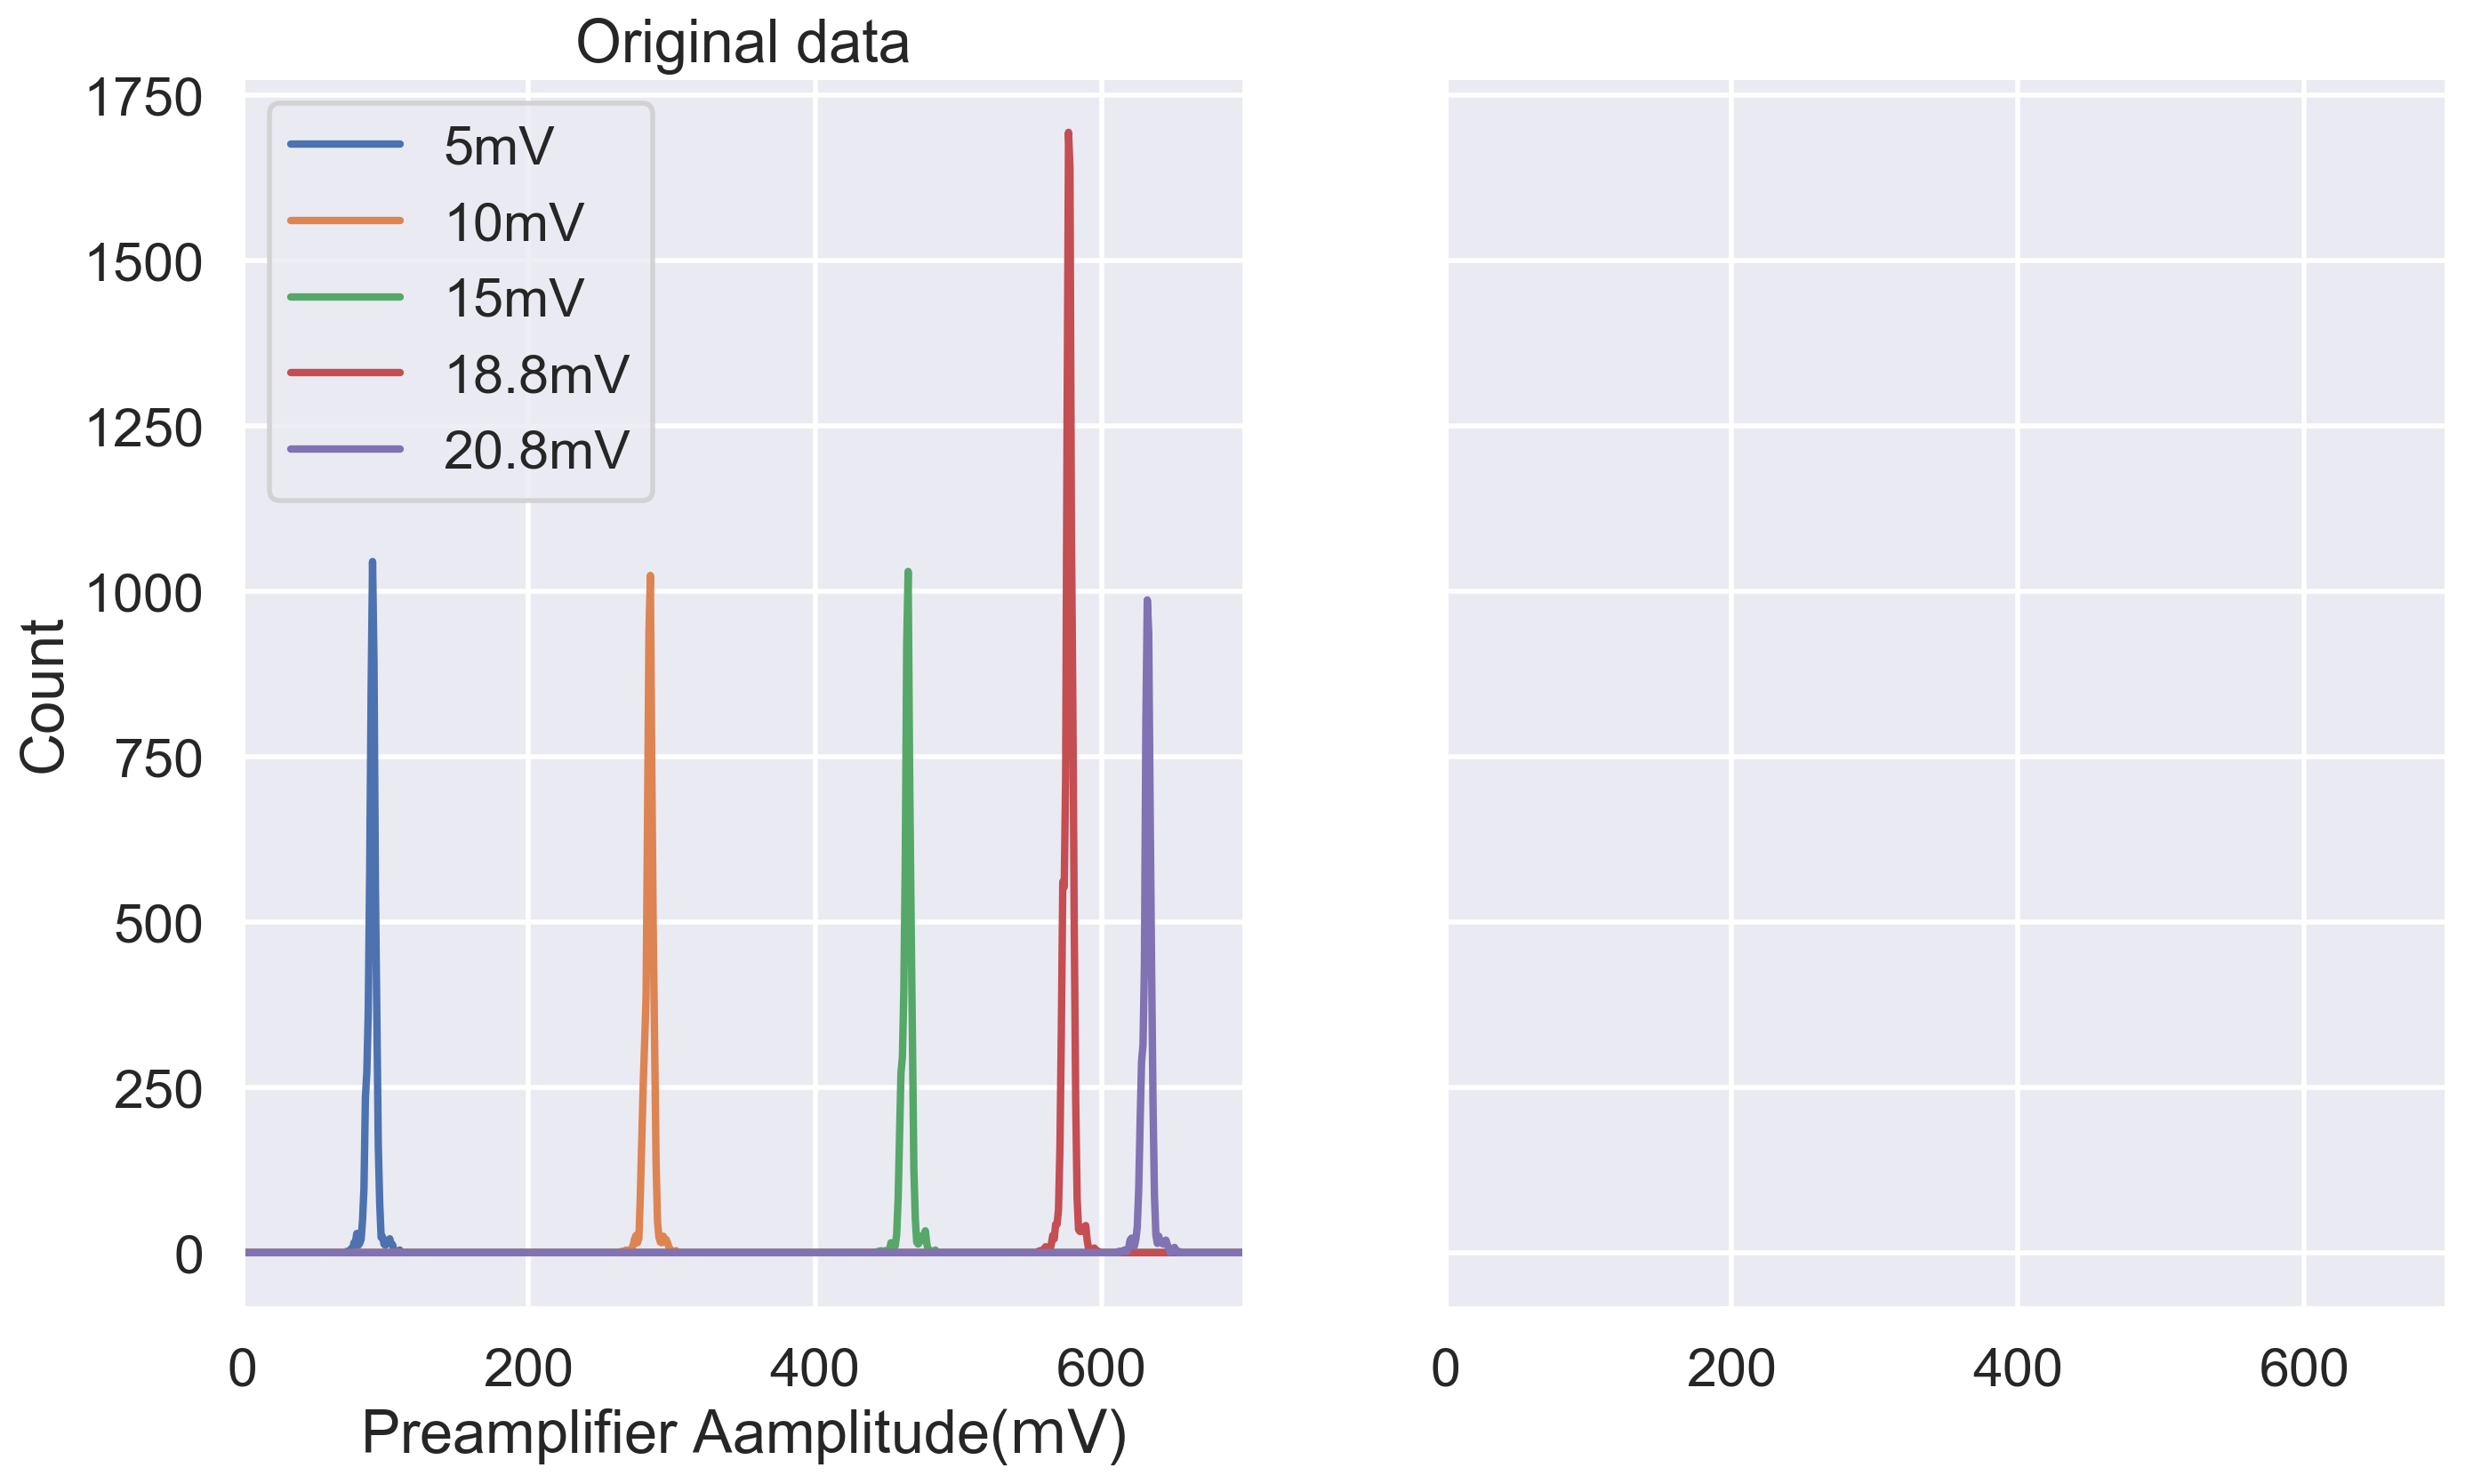

In [110]:
fig,axes = plt.subplots(1,2,figsize=(16,9),sharex=True,sharey=True)
data_linear_celibration.plot(ax = axes[0])
axes[0].set_xlim(0,700)
axes[0].set_title('Original data')
axes[0].set_xlabel(r'Preamplifier Aamplitude($\rm{mV}$)')
axes[0].set_ylabel('Count')

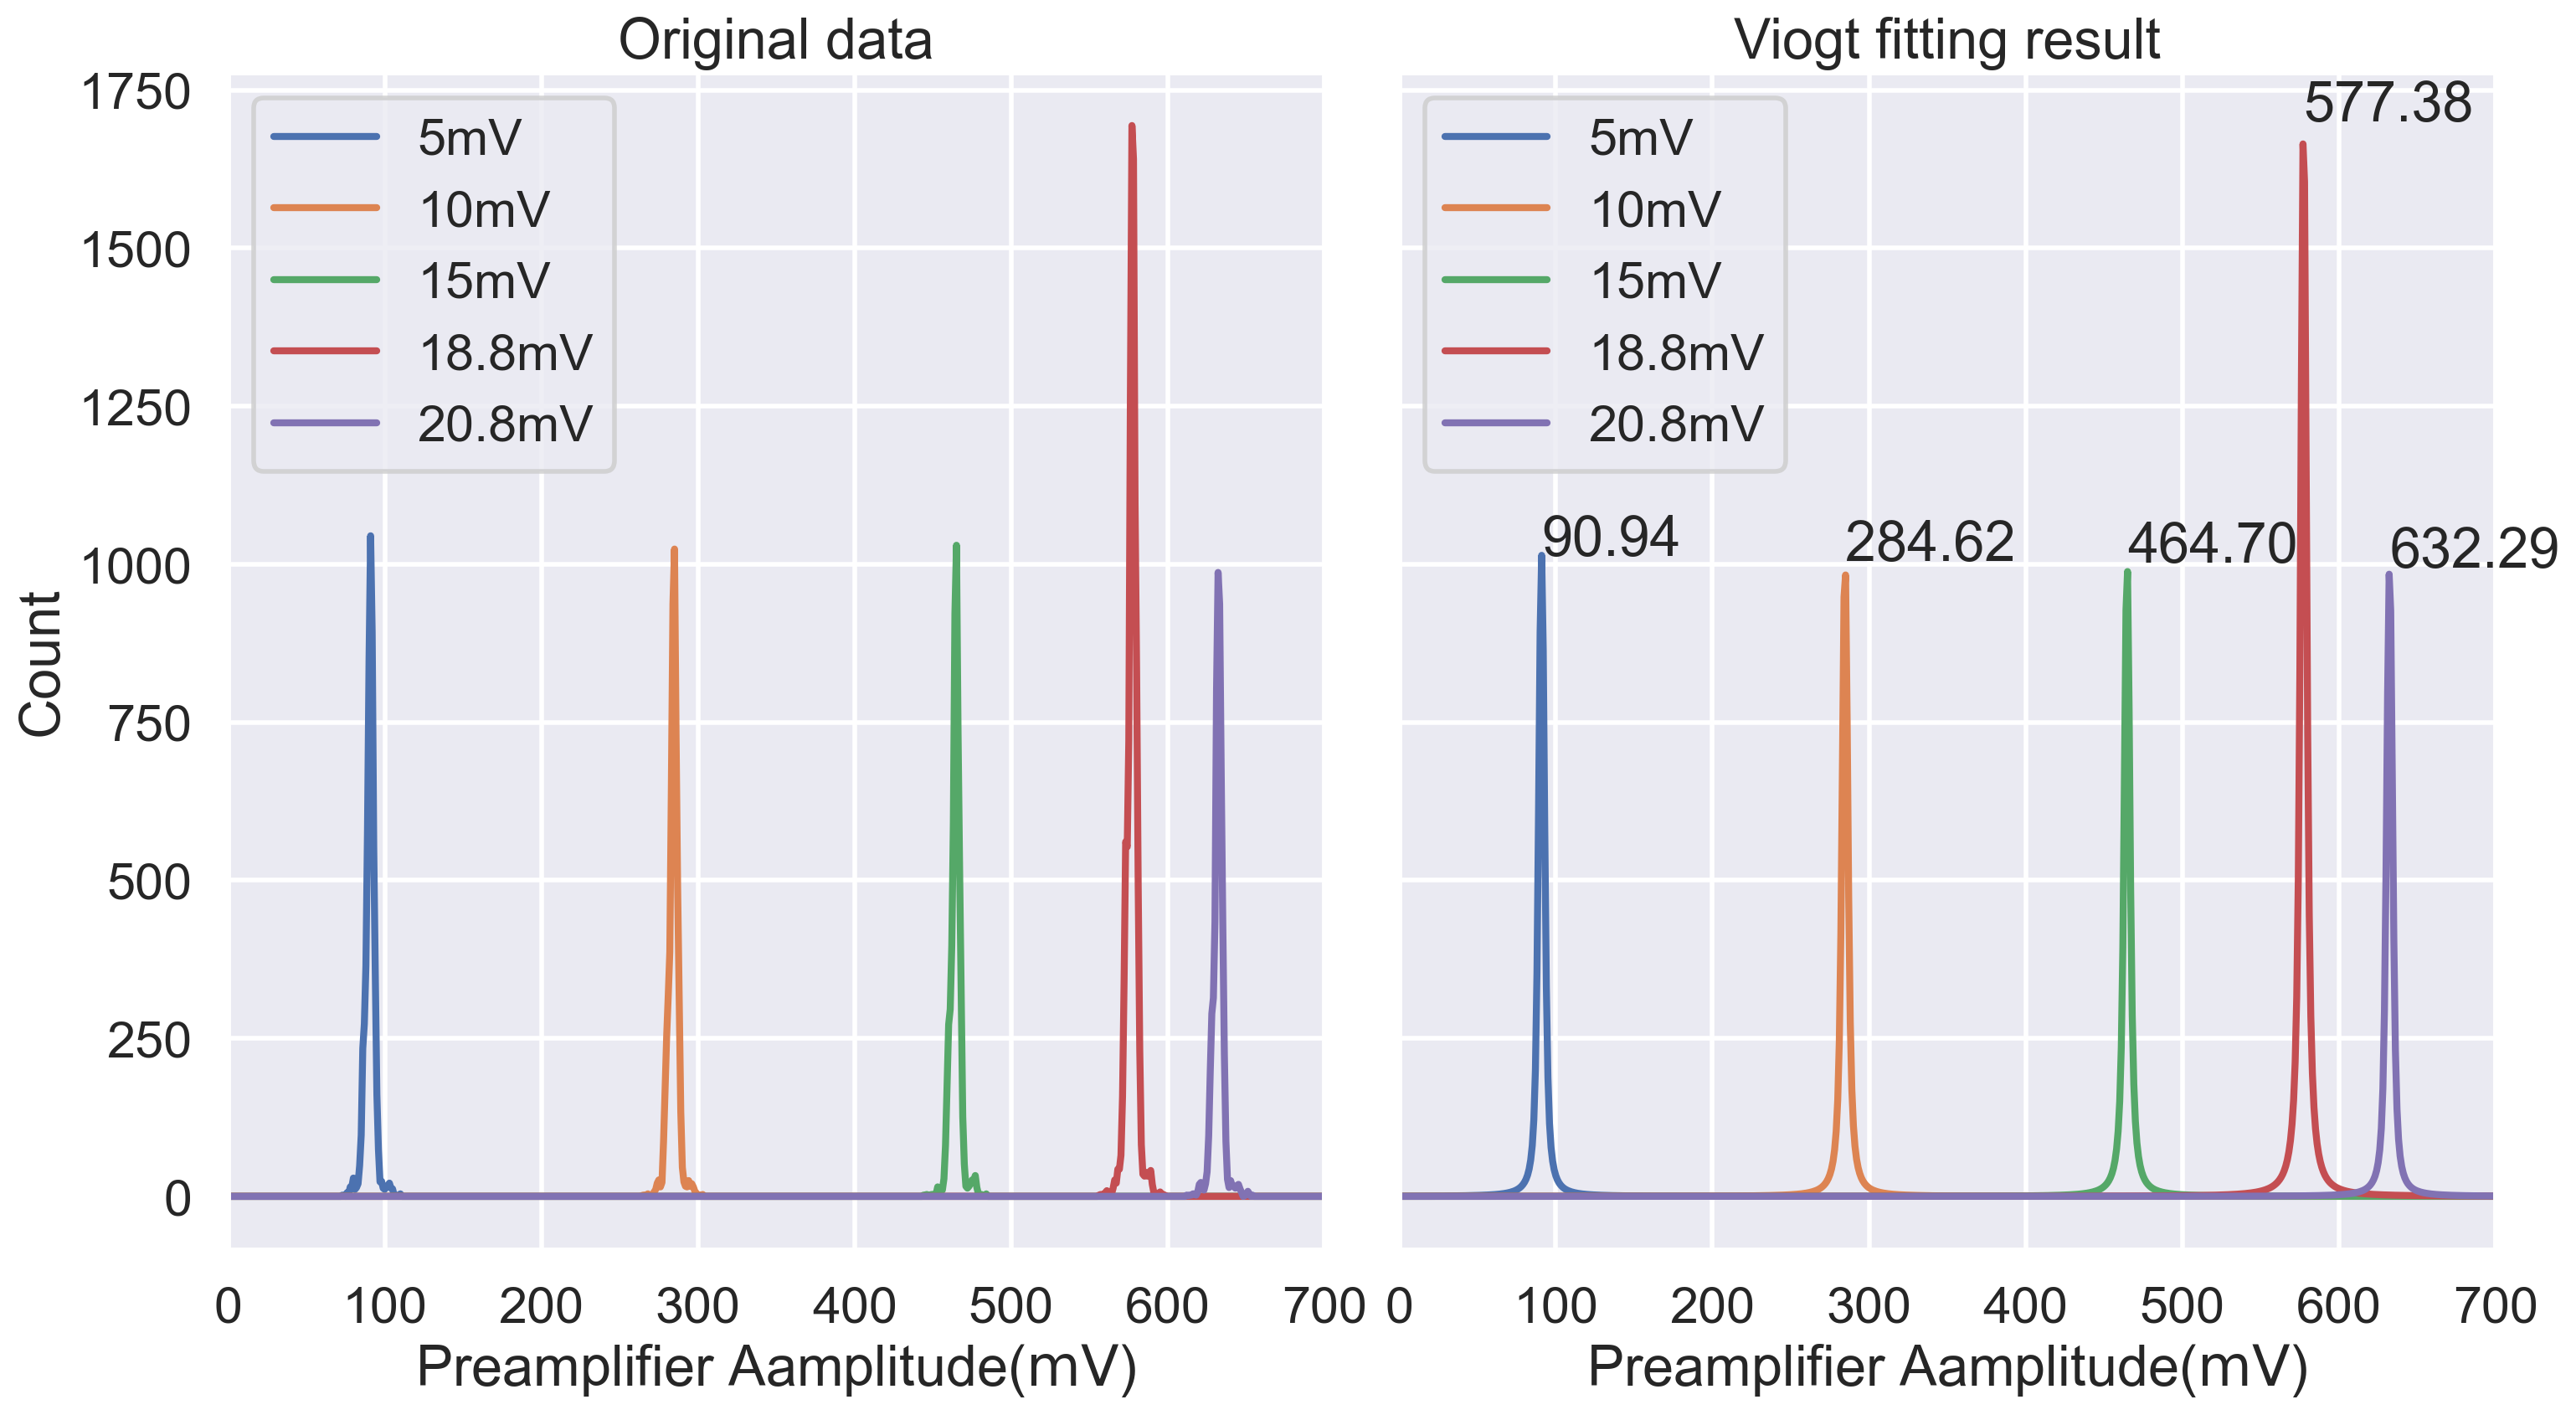

([91, 285, 465, 577, 632],
 [90.94315096147045,
  284.615449197184,
  464.69686662489113,
  577.3777226325575,
  632.286003704376])

In [111]:
peaks = []
peaks_voigt = []
for col in data_linear_celibration.columns:
    data = data_linear_celibration[col].values
    x_data = np.arange(0,len(data),1)
    peak,_ = find_peaks(data, prominence = 800 )
    peaks.append(peak[0])
    model = VoigtModel()
    params = model.guess(data, x=x_data)
    params['gamma'].set(vary=True)
    result = model.fit(data, params, x=x_data)
    peaks_voigt.append(result.params['center'].value)
    axes[1].plot(x_data, result.best_fit, label=col)
    axes[1].text(result.params['center'].value, result.params['height'].value,
                 f'{result.params['center'].value:.2f}')

axes[1].set_title('Viogt fitting result')
axes[1].set_xlabel(r'Preamplifier Aamplitude($\rm{mV}$)')
axes[1].set_ylabel('Count')
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')
fig.tight_layout()
fig.savefig(path + 'linear_celibration.pdf')
display(fig)

peaks,peaks_voigt

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 5
    # variables        = 2
    chi-square         = 752.959090
    reduced chi-square = 250.986363
    Akaike info crit   = 29.0728649
    Bayesian info crit = 28.2917407
    R-squared          = 0.99619596
[[Variables]]
    slope:      34.3364234 +/- 1.22502400 (3.57%) (init = 1)
    intercept: -67.9791756 +/- 18.4656267 (27.16%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9235


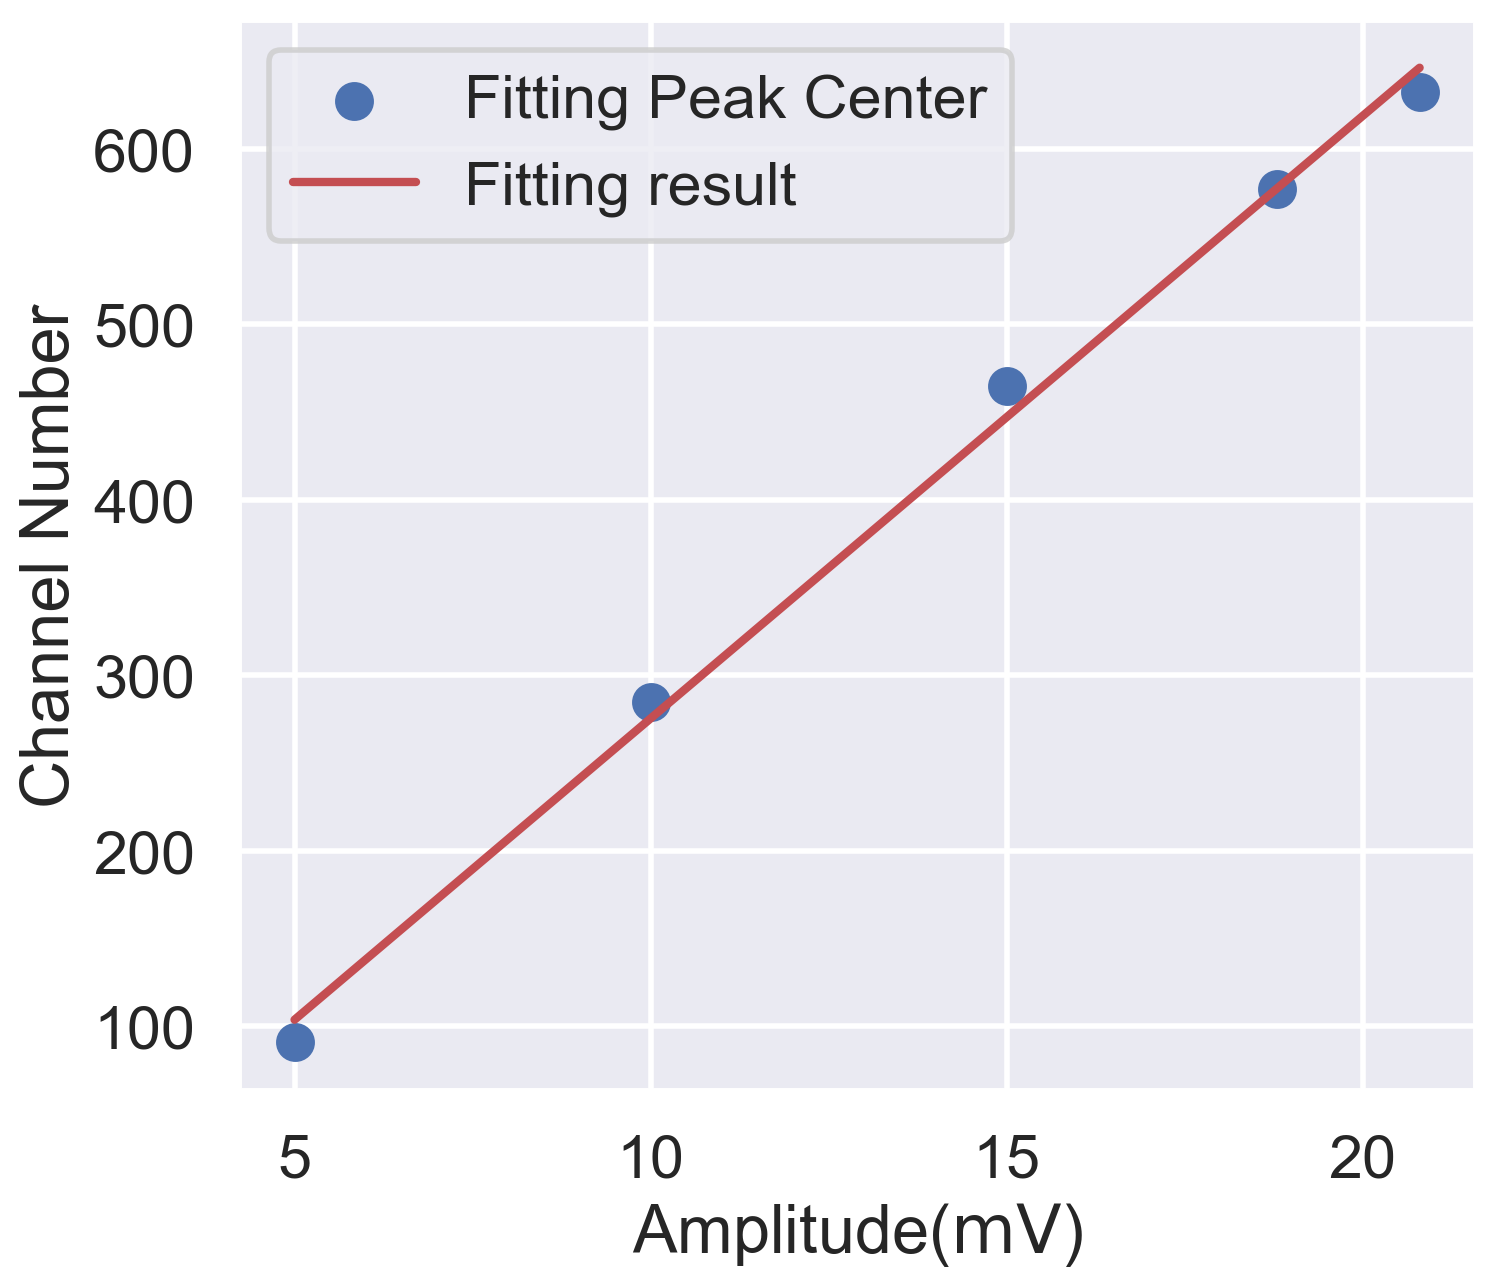

In [73]:
x = [eval(i[:-2]) for i in data_linear_celibration.columns]
y = peaks_voigt

linear_model = LinearModel()
fit_result = linear_model.fit(y, x=x)

print(fit_result.fit_report())

plt.figure(figsize=(8, 7))
plt.scatter(x, y, label='Fitting Peak Center')
x_plot = np.linspace(min(x), max(x), 1001)
plt.plot(x_plot,
         fit_result.eval(x=x_plot),
         label='Fitting result', color='r')
plt.xlabel(r'Amplitude(${\rm mV}$)')
plt.ylabel(r'Channel Number')
plt.legend()
plt.tight_layout()
plt.savefig(path+'linear_fit.pdf')
plt.show()

In [74]:
celi_B = fit_result.params['slope'].value
celi_Bstderr = fit_result.params['slope'].stderr
print(celi_B,celi_Bstderr)

34.3364234408808 1.2250239979234592


## One Energy Celibration

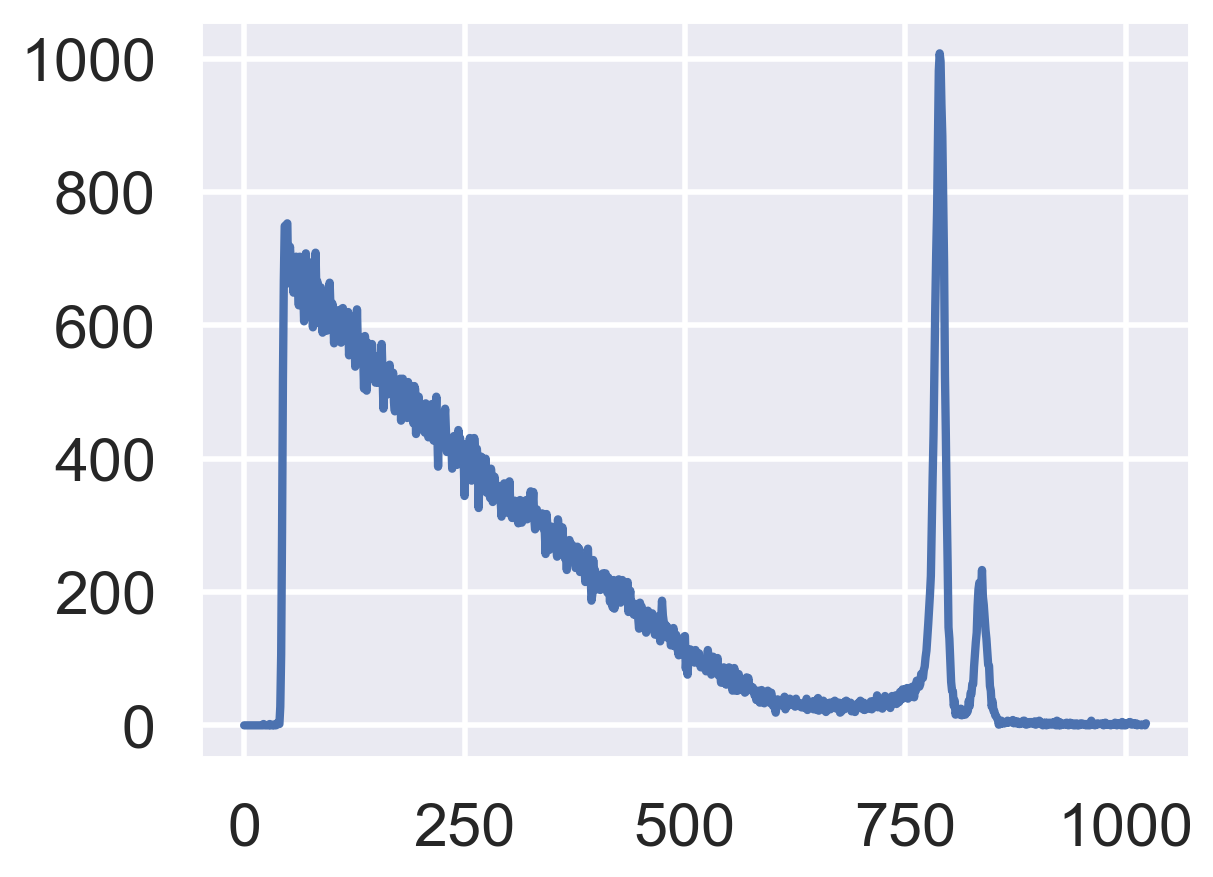

In [75]:
beta_spectrum = pd.read_csv('data/beta/beta.txt', sep='\t')['1'].values
plt.plot(beta_spectrum)
plt.show()

Text(0, 0.5, 'Counts')

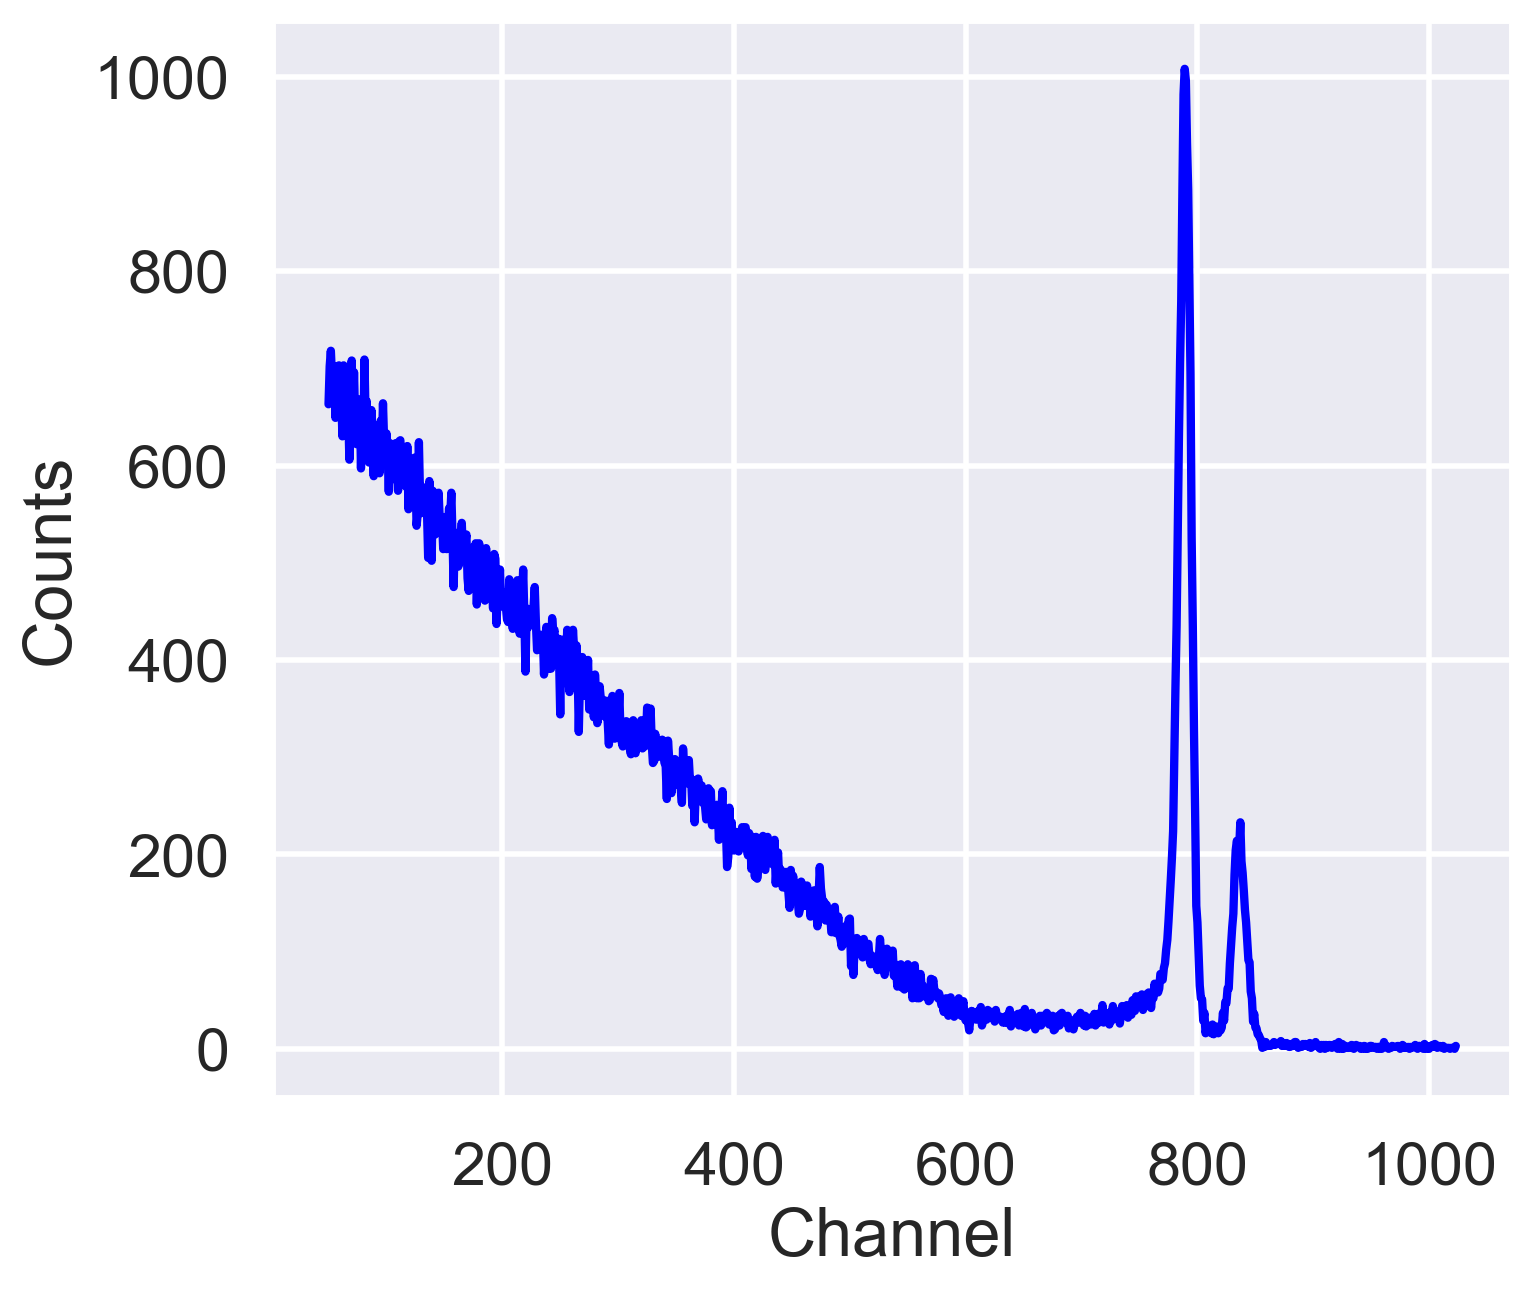

In [77]:
beta_spectrum_dropped = beta_spectrum[50:]
channel_dropped = np.arange(50,1024,1)
# bl = baseline(beta_spectrum[50:],deg=4)
# print(bl)
fig,ax = plt.subplots(figsize = (8,7))
ax.plot(channel_dropped,beta_spectrum_dropped,color = 'blue',label = r'$\beta$ Spectrum')
ax.set_xlabel('Channel')
ax.set_ylabel('Counts')

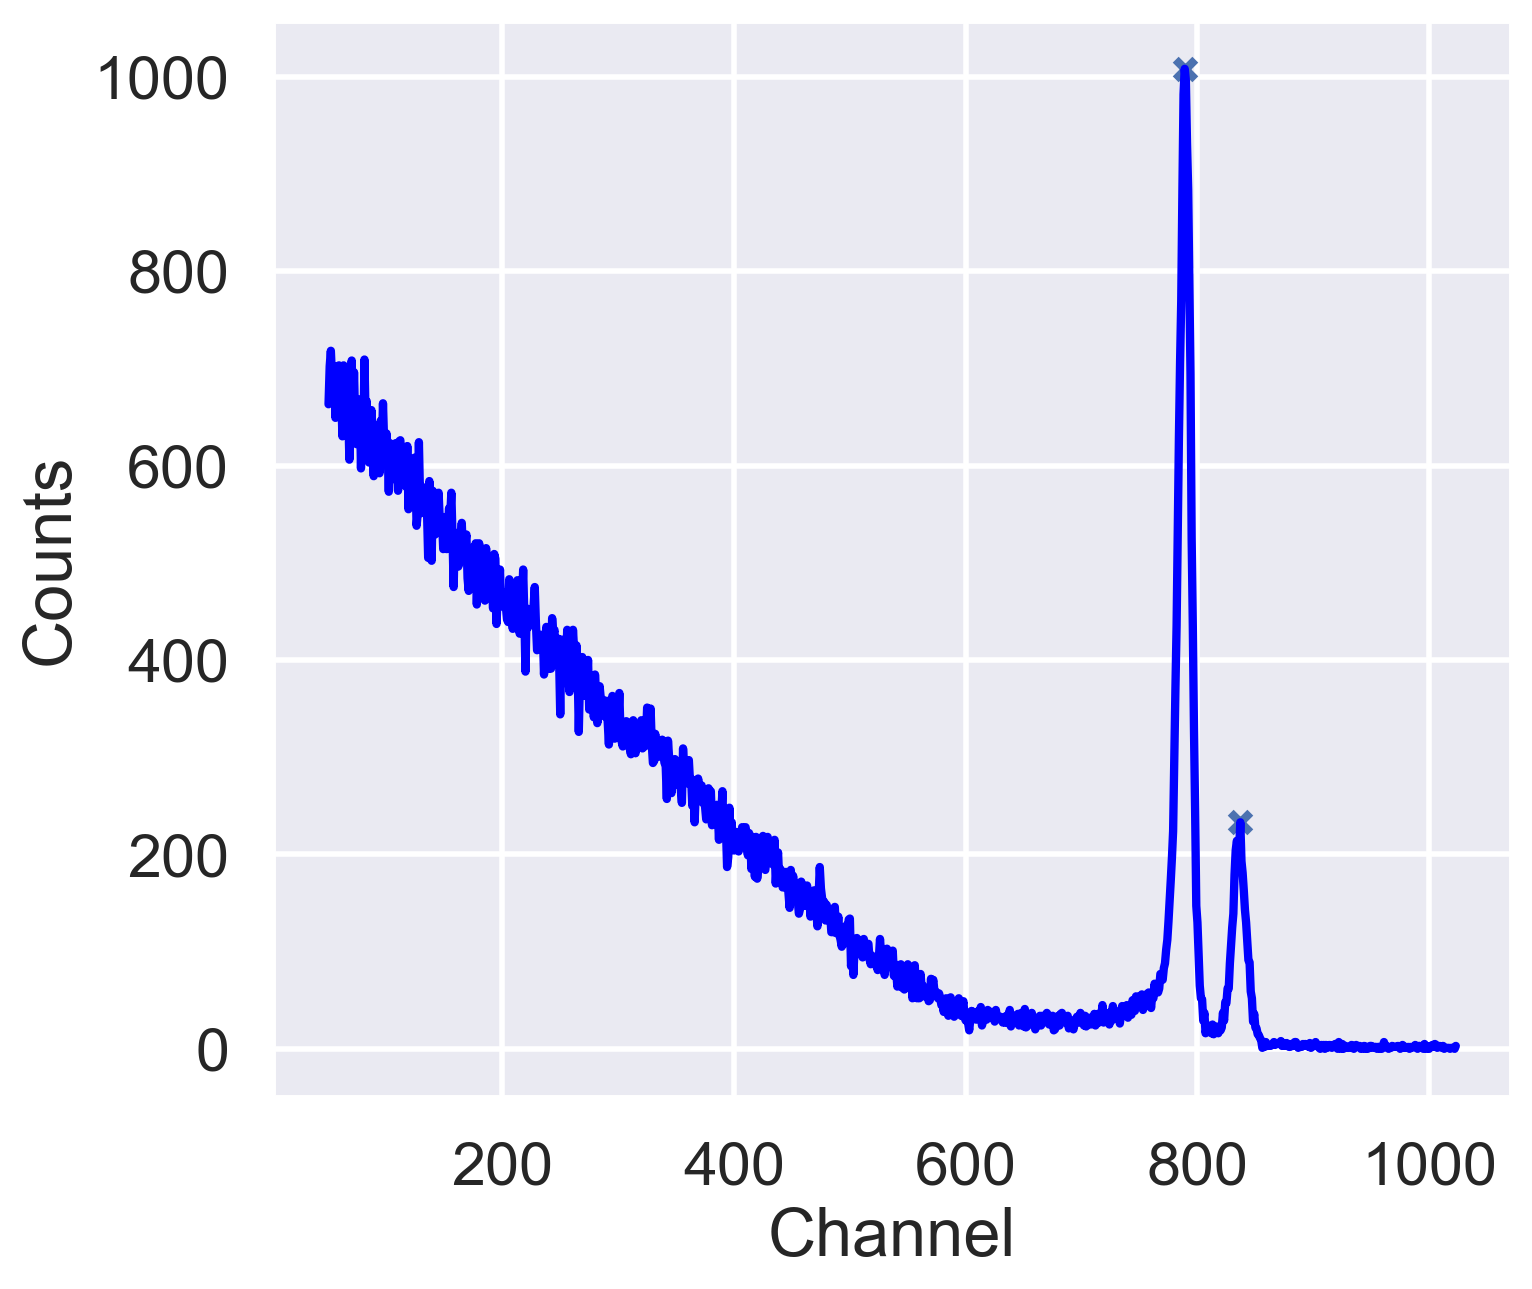

array([789, 837])

In [78]:
peaks,info = find_peaks(beta_spectrum_dropped,prominence=150,width = 10)
ax.scatter(channel_dropped[peaks],beta_spectrum_dropped[peaks],marker='x',s = 50)
display(fig)
channel_dropped[peaks]

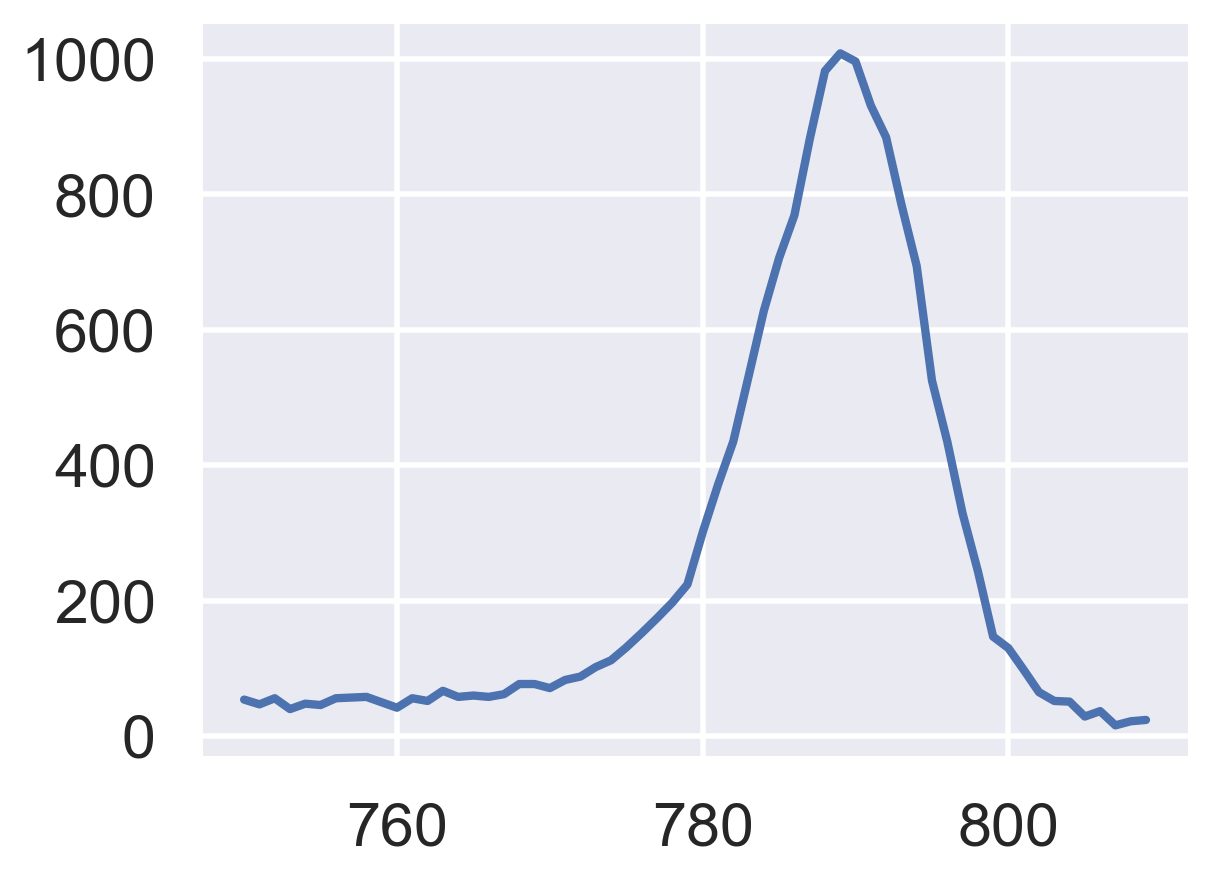

In [79]:
plt.plot(channel_dropped[700:760],beta_spectrum_dropped[700:760])

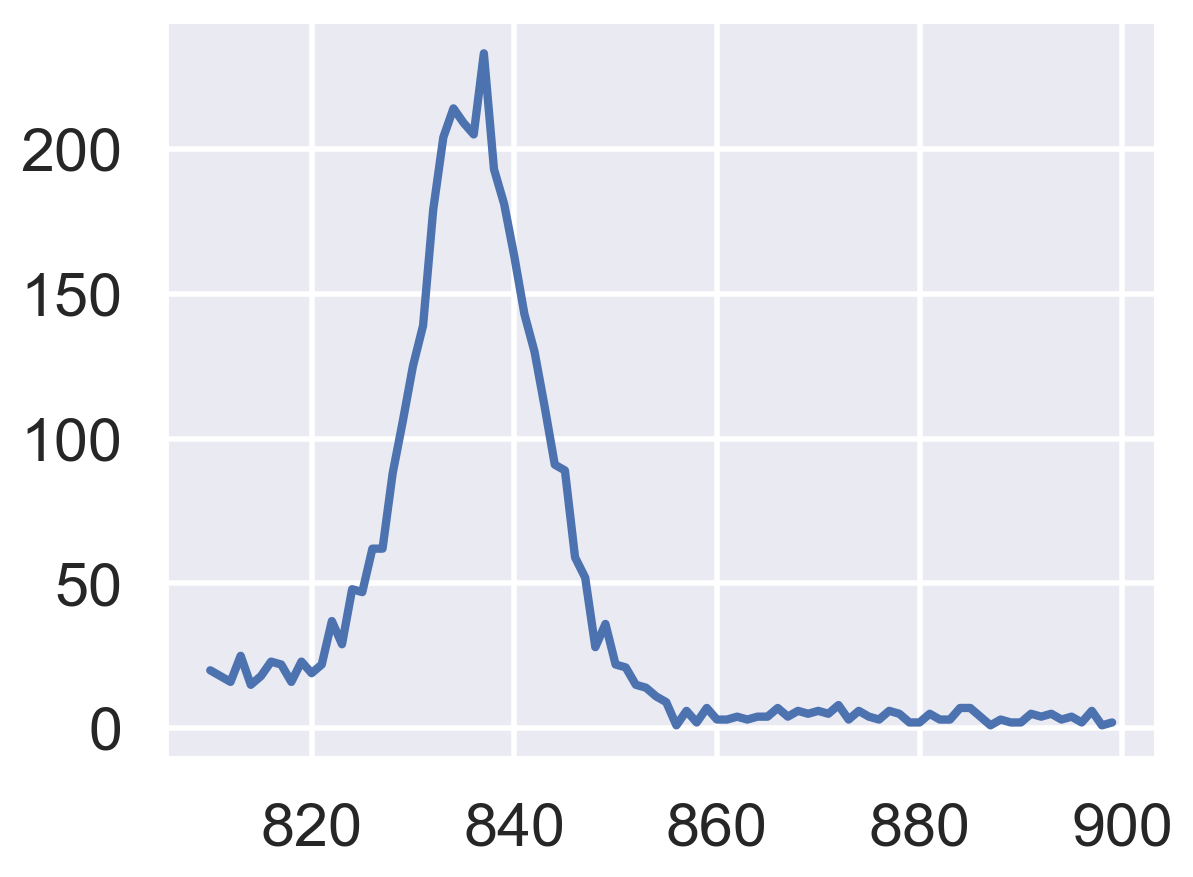

In [80]:
plt.plot(channel_dropped[760:850],beta_spectrum_dropped[760:850])

In [81]:
Viogt1 = VoigtModel(prefix='peak1_')
# params = Viogt1.make_params(center=channel_dropped[peaks[0]],amplitude = 1000,)
params = Viogt1.guess(beta_spectrum_dropped[700:760],channel_dropped[700:760])
Viogt2 = VoigtModel(prefix='peak2_')
params.update(Viogt2.guess(beta_spectrum_dropped[760:850],channel_dropped[760:850]))
params['peak1_gamma'].set(value = 0.7,vary=True,min = 0)
params['peak2_gamma'].set(value = 0.7,vary=True,min = 0)
knot_xvals = np.arange(200,1100,100)
bkg = SplineModel(prefix='bkg_', xknots=knot_xvals)
params.update(bkg.guess(beta_spectrum_dropped, channel_dropped))

name,value,initial value,min,max,vary,expression
peak1_amplitude,26784.0000,26784.0,-inf,inf,True,
peak1_center,789.000000,789.0,-inf,inf,True,
peak1_sigma,3.90000000,3.9000000000000004,0.00000000,inf,True,
peak1_gamma,0.70000000,0.7,0.00000000,inf,True,
peak1_fwhm,9.95524446,None,-inf,inf,False,1.0692*peak1_gamma+sqrt(0.8664*peak1_gamma**2+5.545083*peak1_sigma**2)
peak1_height,2387.69313,None,-inf,inf,False,"(peak1_amplitude/(max(1e-15, peak1_sigma*sqrt(2*pi))))*real(wofz((1j*peak1_gamma)/(max(1e-15, peak1_sigma*sqrt(2)))))"
peak2_amplitude,6264.00000,6264.0,-inf,inf,True,
peak2_center,836.000000,836.0,-inf,inf,True,
peak2_sigma,3.90000000,3.9000000000000004,0.00000000,inf,True,
peak2_gamma,0.70000000,0.7,0.00000000,inf,True,


In [82]:
model = Viogt1 + Viogt2 + bkg
out = model.fit(beta_spectrum_dropped, params, x=channel_dropped)
print(out.fit_report(min_correl=0.3))

[[Model]]
    ((Model(voigt, prefix='peak1_') + Model(voigt, prefix='peak2_')) + Model(spline_model, prefix='bkg_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 264
    # data points      = 974
    # variables        = 17
    chi-square         = 234693.621
    reduced chi-square = 245.238894
    Akaike info crit   = 5376.02465
    Bayesian info crit = 5459.00864
    R-squared          = 0.99495858
[[Variables]]
    peak1_amplitude:  14712.6809 +/- 295.095005 (2.01%) (init = 26784)
    peak1_center:     789.072731 +/- 0.04085994 (0.01%) (init = 789)
    peak1_sigma:      4.27582023 +/- 0.16031160 (3.75%) (init = 3.9)
    peak1_gamma:      2.02300159 +/- 0.25462211 (12.59%) (init = 0.7)
    peak1_fwhm:       12.4062604 +/- 0.12391095 (1.00%) == '1.0692*peak1_gamma+sqrt(0.8664*peak1_gamma**2+5.545083*peak1_sigma**2)'
    peak1_height:     976.633845 +/- 8.08753220 (0.83%) == '(peak1_amplitude/(max(1e-15, peak1_sigma*sqrt(2*pi))))*real(wofz((1j*peak1_gamma

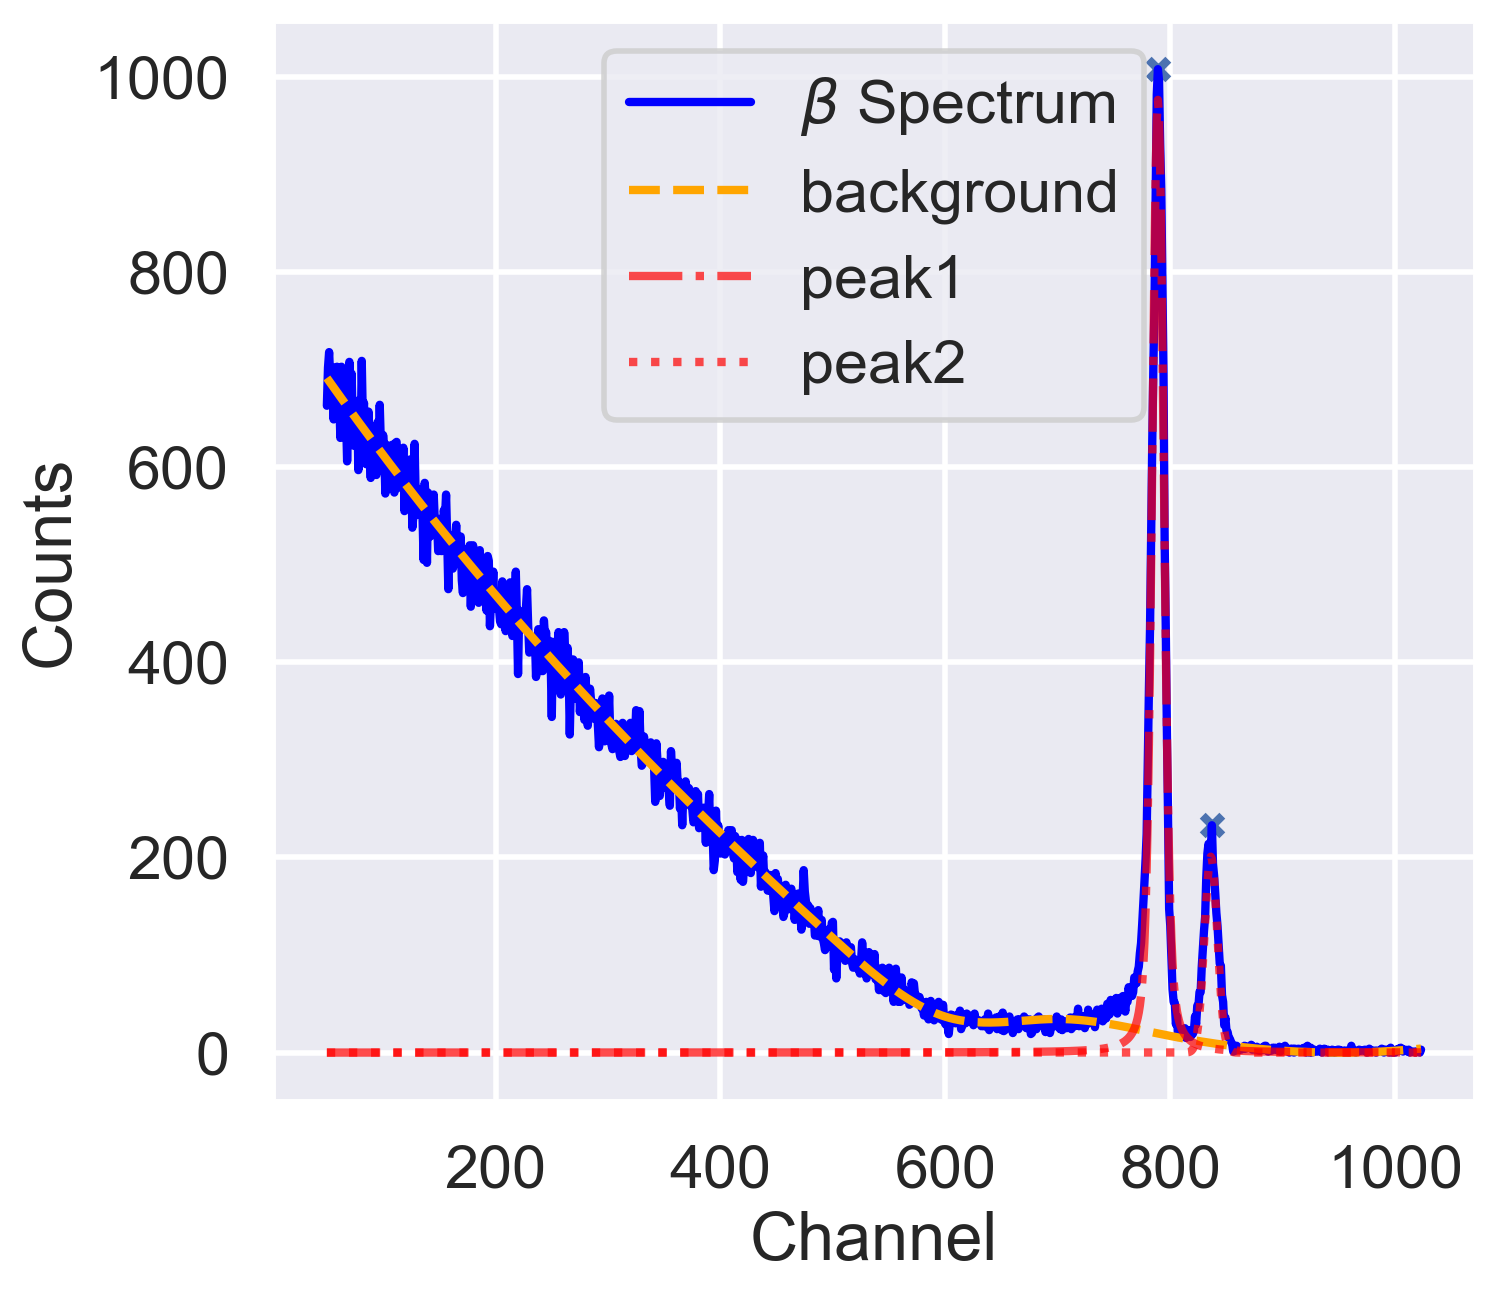

In [83]:
# ax.plot(channel_dropped,out.best_fit,'r',label='fit')
comps = out.eval_components()
ax.plot(channel_dropped, comps['bkg_'], color = 'orange',label='background',linestyle = '--')
ax.plot(channel_dropped, comps['peak1_'],color='red', label='peak1',linestyle = '-.',alpha = 0.7)
ax.plot(channel_dropped, comps['peak2_'],color='red', label='peak2',linestyle = 'dotted',alpha = 0.7)
ax.legend()
fig.tight_layout()
fig.savefig(path+'beta_spectrum.pdf')
fig

In [84]:
Channel_inner = out.params['peak1_center'].value
E_inner = 625 #keV

1.2075780915652834


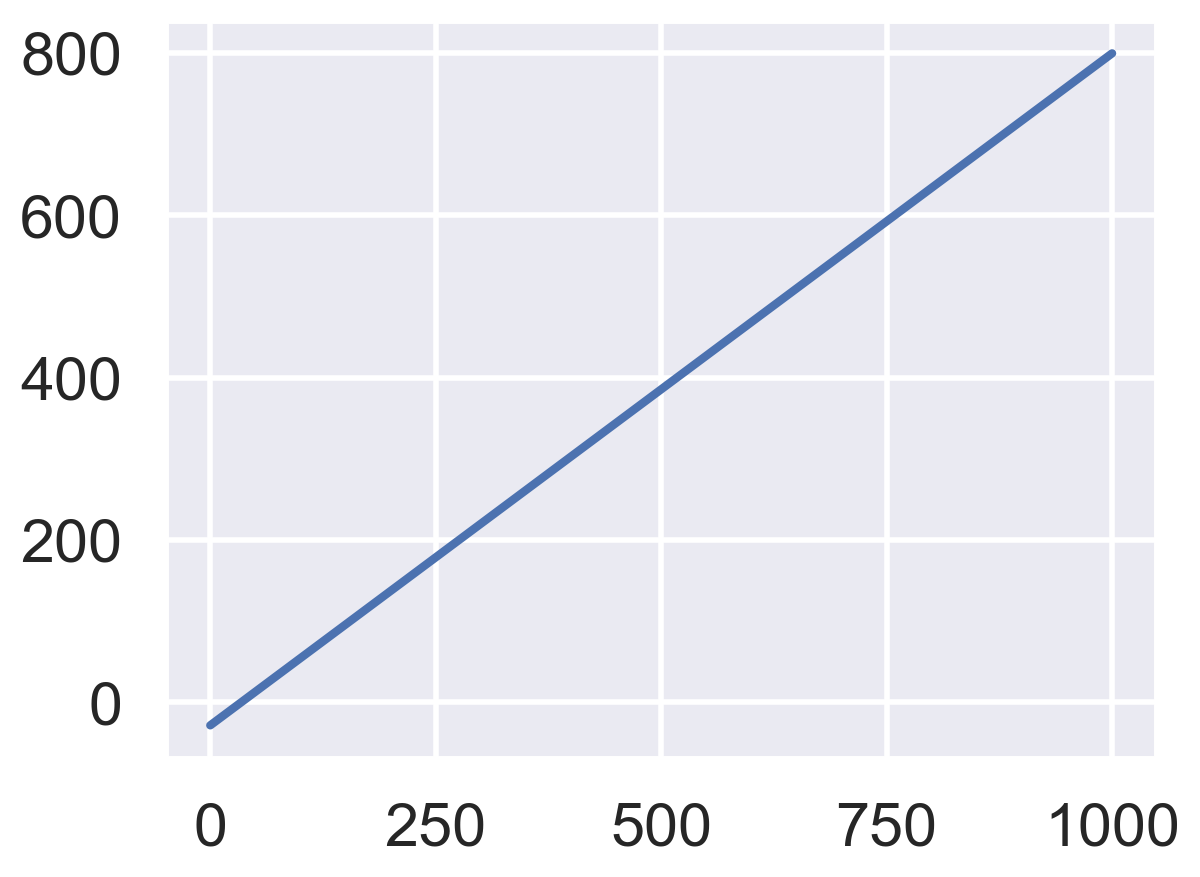

In [85]:
celi_A = (Channel_inner-celi_B)/E_inner
print(celi_A)

def celibration(h):
    return (h-celi_B)/celi_A

Ene_plot = np.linspace(0,1000,1001)
channel_plot = celibration(Ene_plot)
plt.plot(Ene_plot,channel_plot)
plt.show()

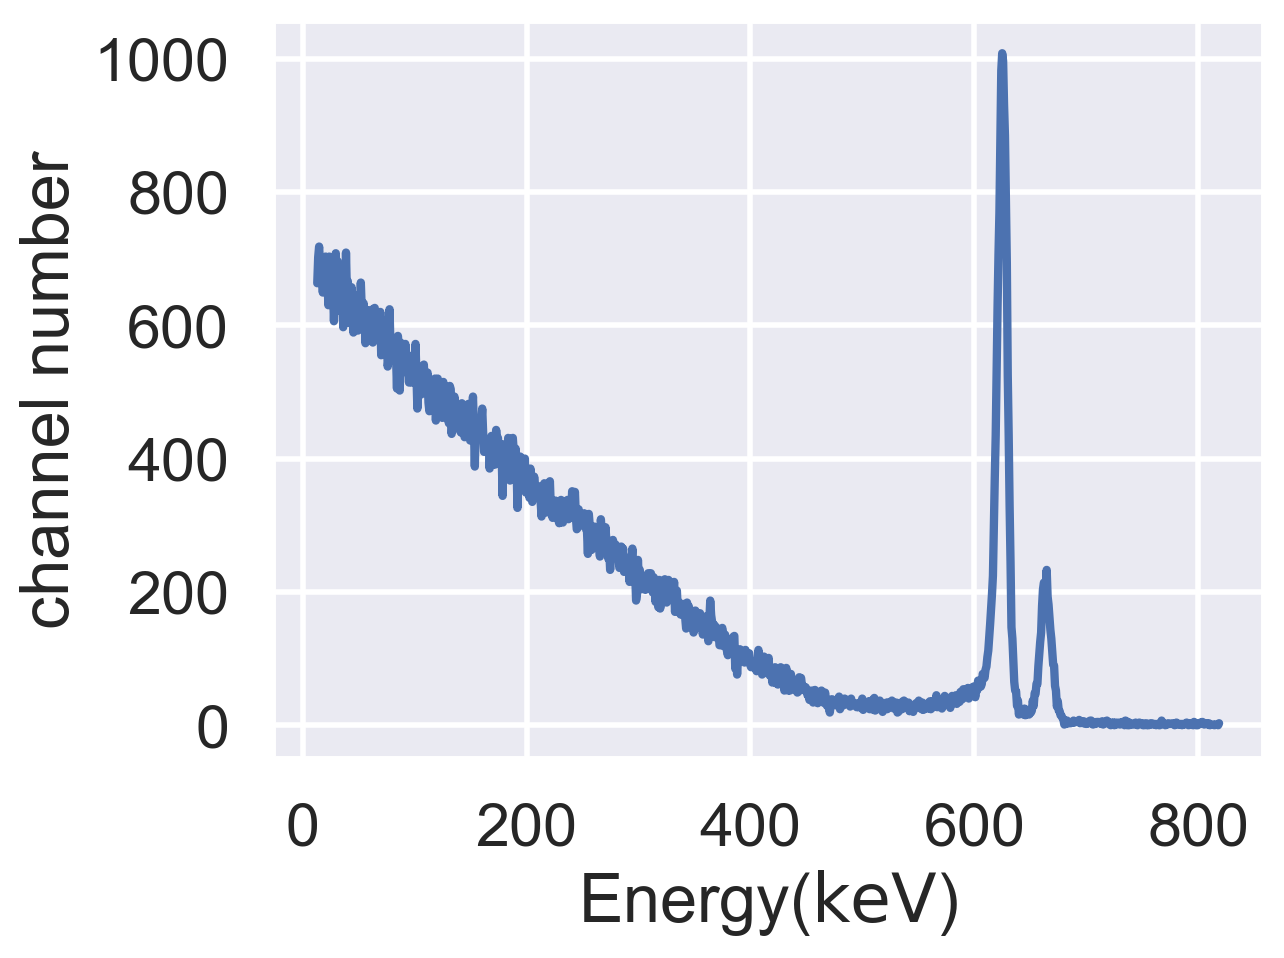

In [86]:
plt.plot(celibration(channel_dropped),beta_spectrum_dropped)
plt.xlabel(r'Energy(${\rm keV}$)')
plt.ylabel('channel number')
plt.show()

# Kurie Plot

## Modifyed Fermi Function

the unit for p in `.csv` is the $\rm MeV$?

In [87]:
Mod_Fermi_data = pd.read_csv('Fermi-function.CSV')
Mod_Fermi_data.head()

,p,G
0,0.0,6.270
1,0.1,6.261
2,0.2,6.234
3,0.3,6.191
4,0.4,6.137


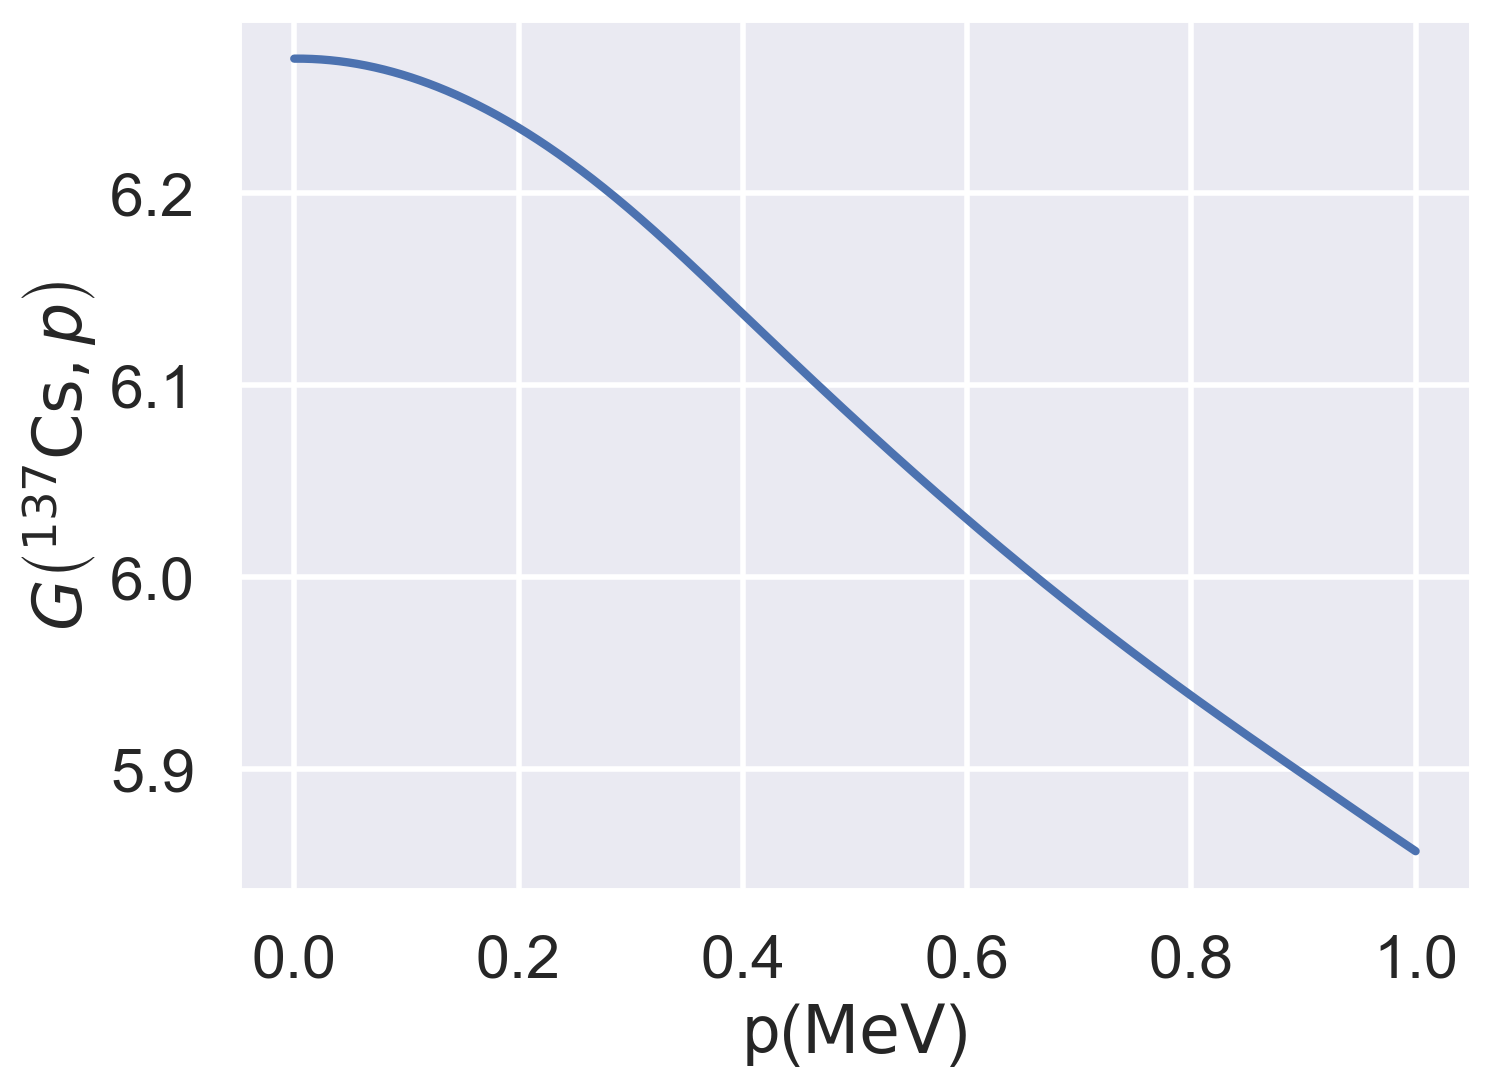

In [89]:
#using pandas read data from Fermi-function.CSV
Mod_Fermi_data = pd.read_csv('Fermi-function.CSV')
omega = Mod_Fermi_data['p']
# interploe the data
Mod_Fermi = CubicSpline(omega, Mod_Fermi_data['G'])

p_plot = np.linspace(0, 1, 1001)
plt.figure(figsize=(8, 6))
plt.plot(p_plot, Mod_Fermi(p_plot))
plt.xlabel(r'p($\rm MeV$)')
plt.ylabel(r'$G\left(^{137}{\rm Cs},p \right)$')
plt.tight_layout()
plt.savefig(path+'Modifyed-Fermi-function.pdf')
plt.show()

## $\beta$ spectrum

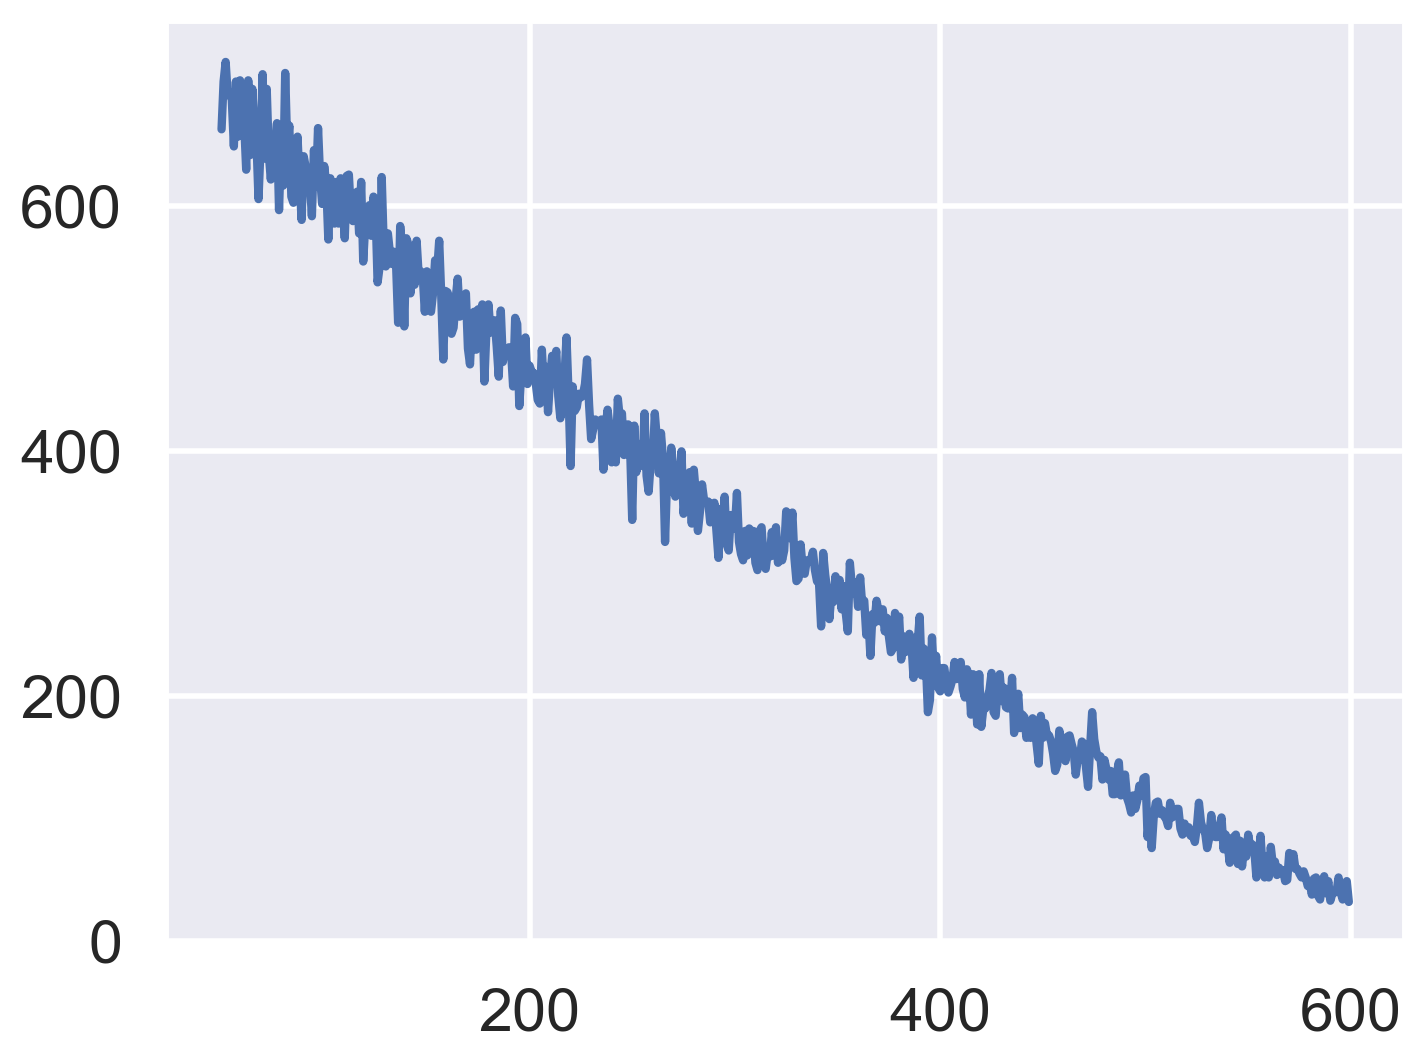

In [91]:
beta_spectrum_noinner = beta_spectrum_dropped[:550]
Channel_noinner = channel_dropped[:550]
plt.figure(figsize=(8,6))
plt.plot(Channel_noinner,beta_spectrum_noinner)

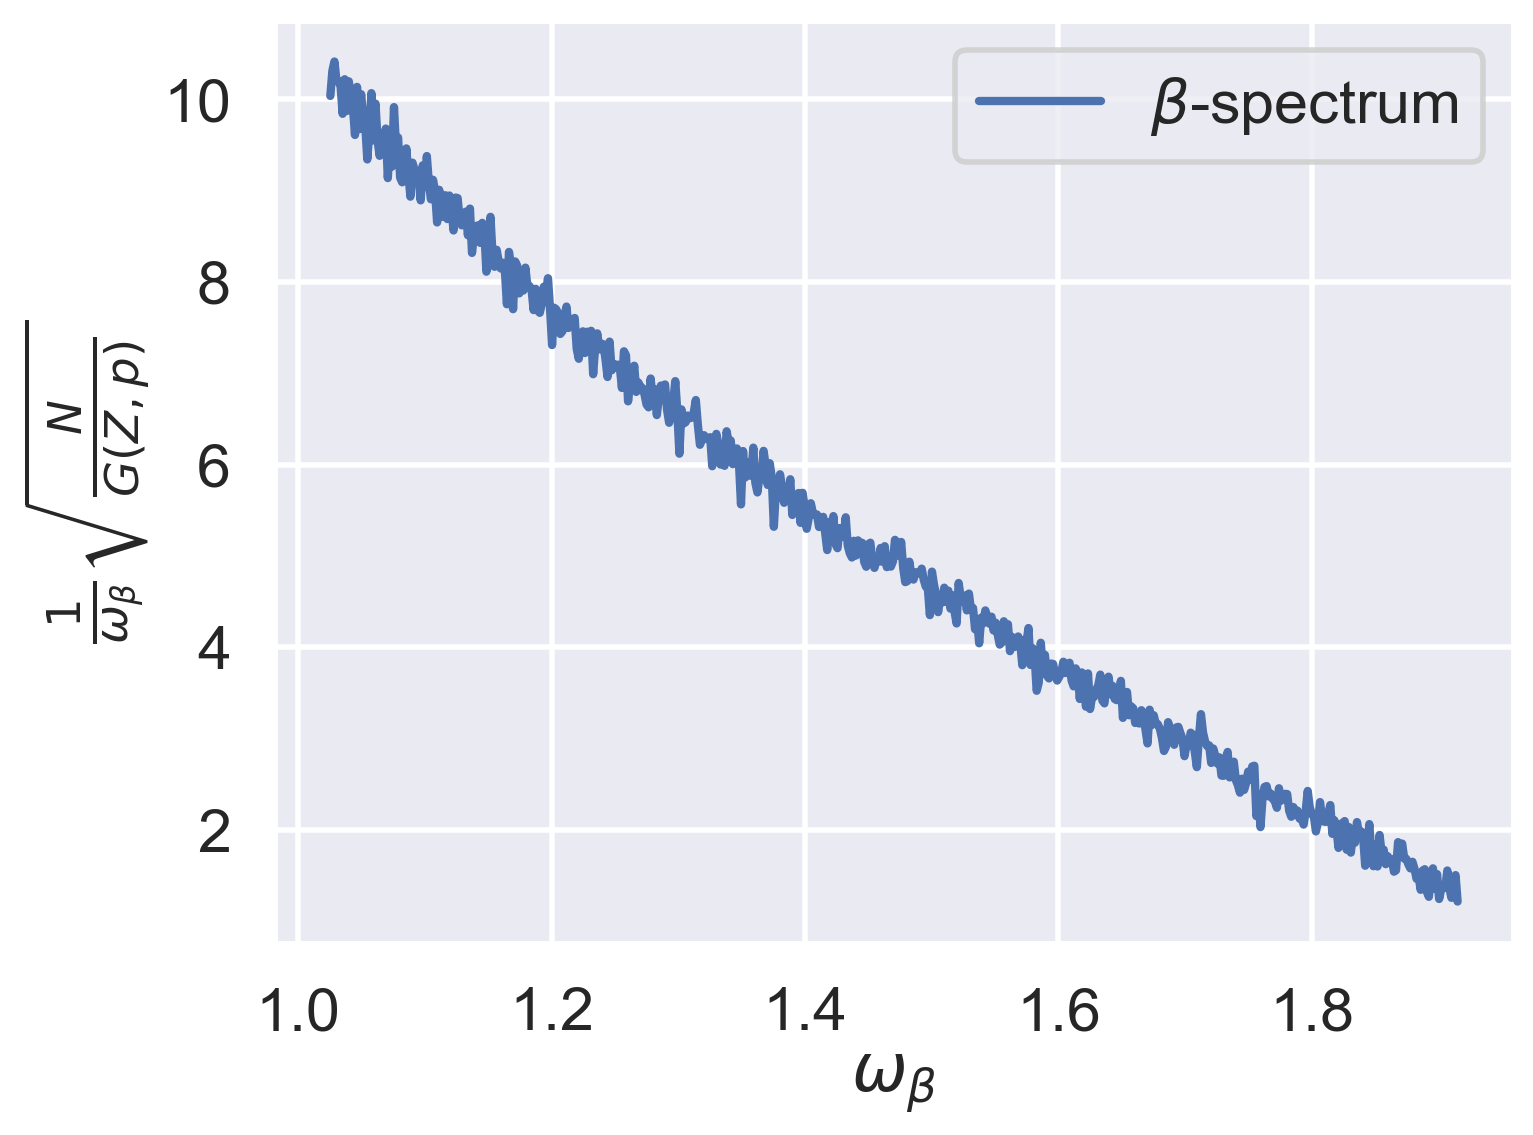

In [97]:
Energy_spectrum_noinner = celibration(Channel_noinner)
omega_spectrum_noinner = Energy_spectrum_noinner/511+1

p_spectrum_noinner = np.sqrt(omega_spectrum_noinner**2-1)
Y_omega = np.sqrt(beta_spectrum_noinner/Mod_Fermi(p_spectrum_noinner*0.511))/omega_spectrum_noinner

fig,ax = plt.subplots(figsize = (8,6))
ax.plot(omega_spectrum_noinner,Y_omega,label = r'$\beta$-spectrum')
ax.set_xlabel(r'$\omega_\beta$')
ax.set_ylabel(r'$\frac{1}{\omega_\beta}\sqrt{\frac{N}{G(Z,p)}}$')
ax.legend()

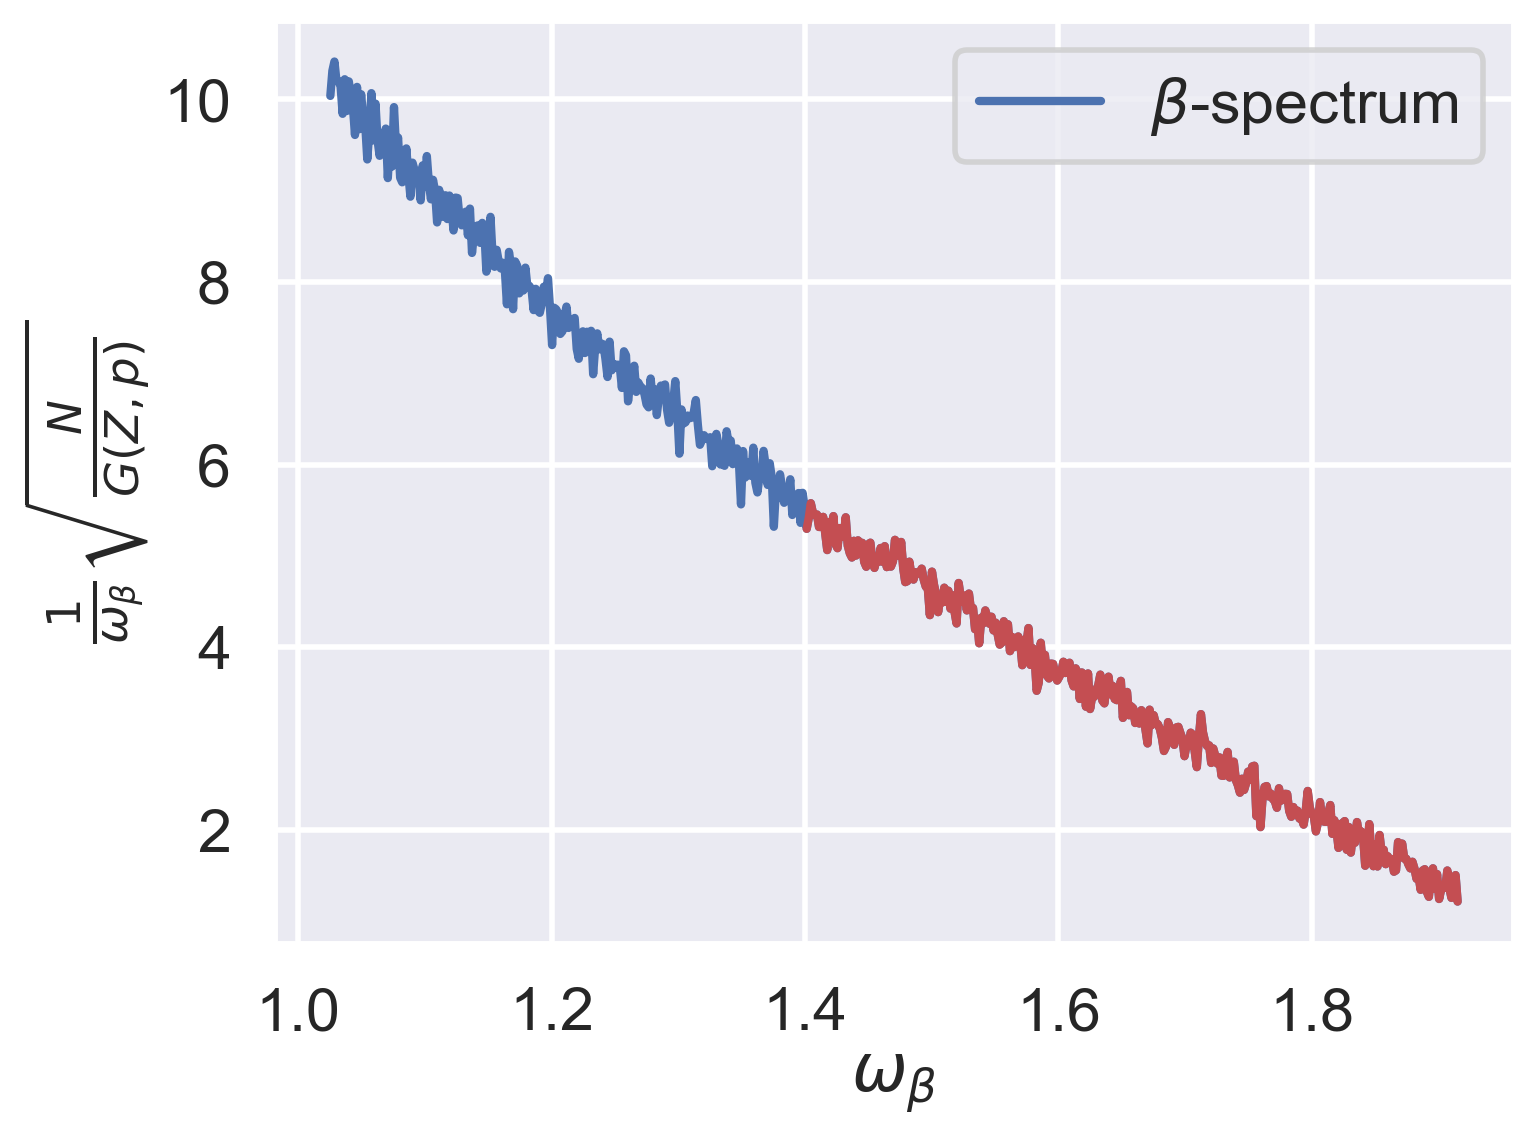

In [98]:
selection = omega_spectrum_noinner>1.4
ax.plot(omega_spectrum_noinner[selection],Y_omega[selection],color = 'r')
fig

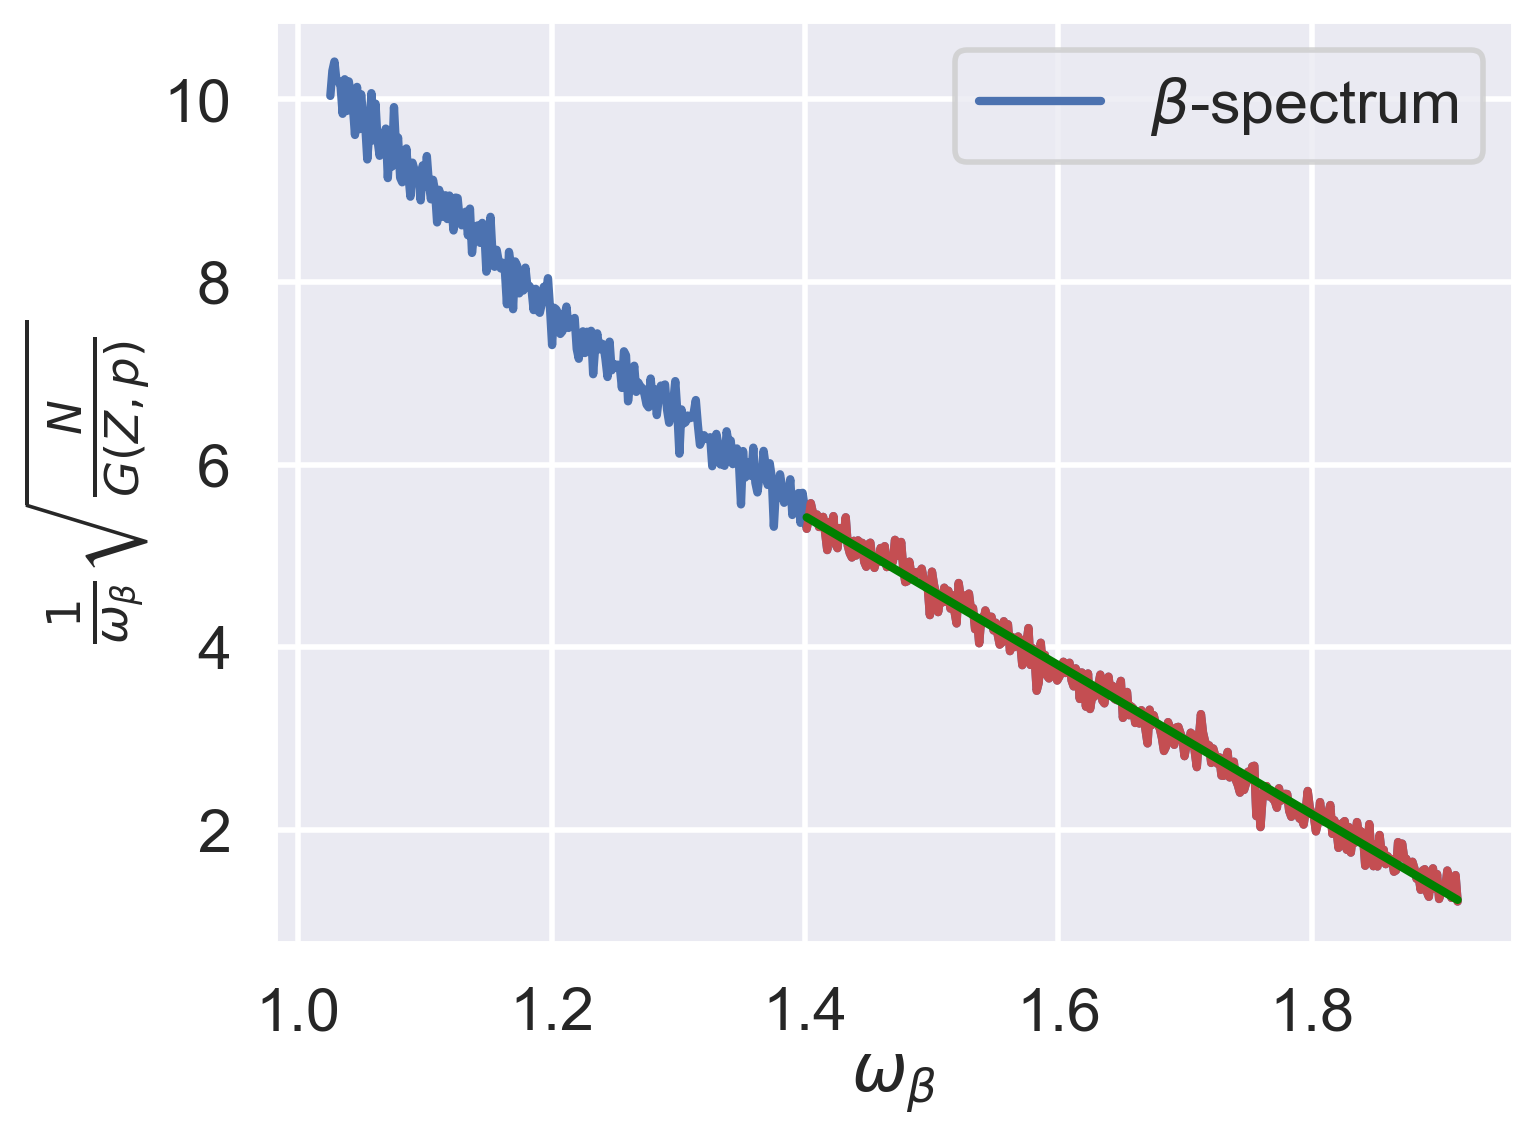

In [99]:
model = LinearModel()
result = model.fit(Y_omega[selection],x = omega_spectrum_noinner[selection])
ax.plot(omega_spectrum_noinner[selection], result.best_fit, 'green', label='fit')
fig

In [100]:
omega_max = -result.params['intercept'].value/result.params['slope'].value
ax.scatter(omega_max,0,marker='x',color='r',s=50,label = 'zero point')
ax.text(omega_max,0,f'{omega_max:.2f}',color='r')
ax.legend()
fig.tight_layout()
fig.savefig(path + 'K_plot.pdf')

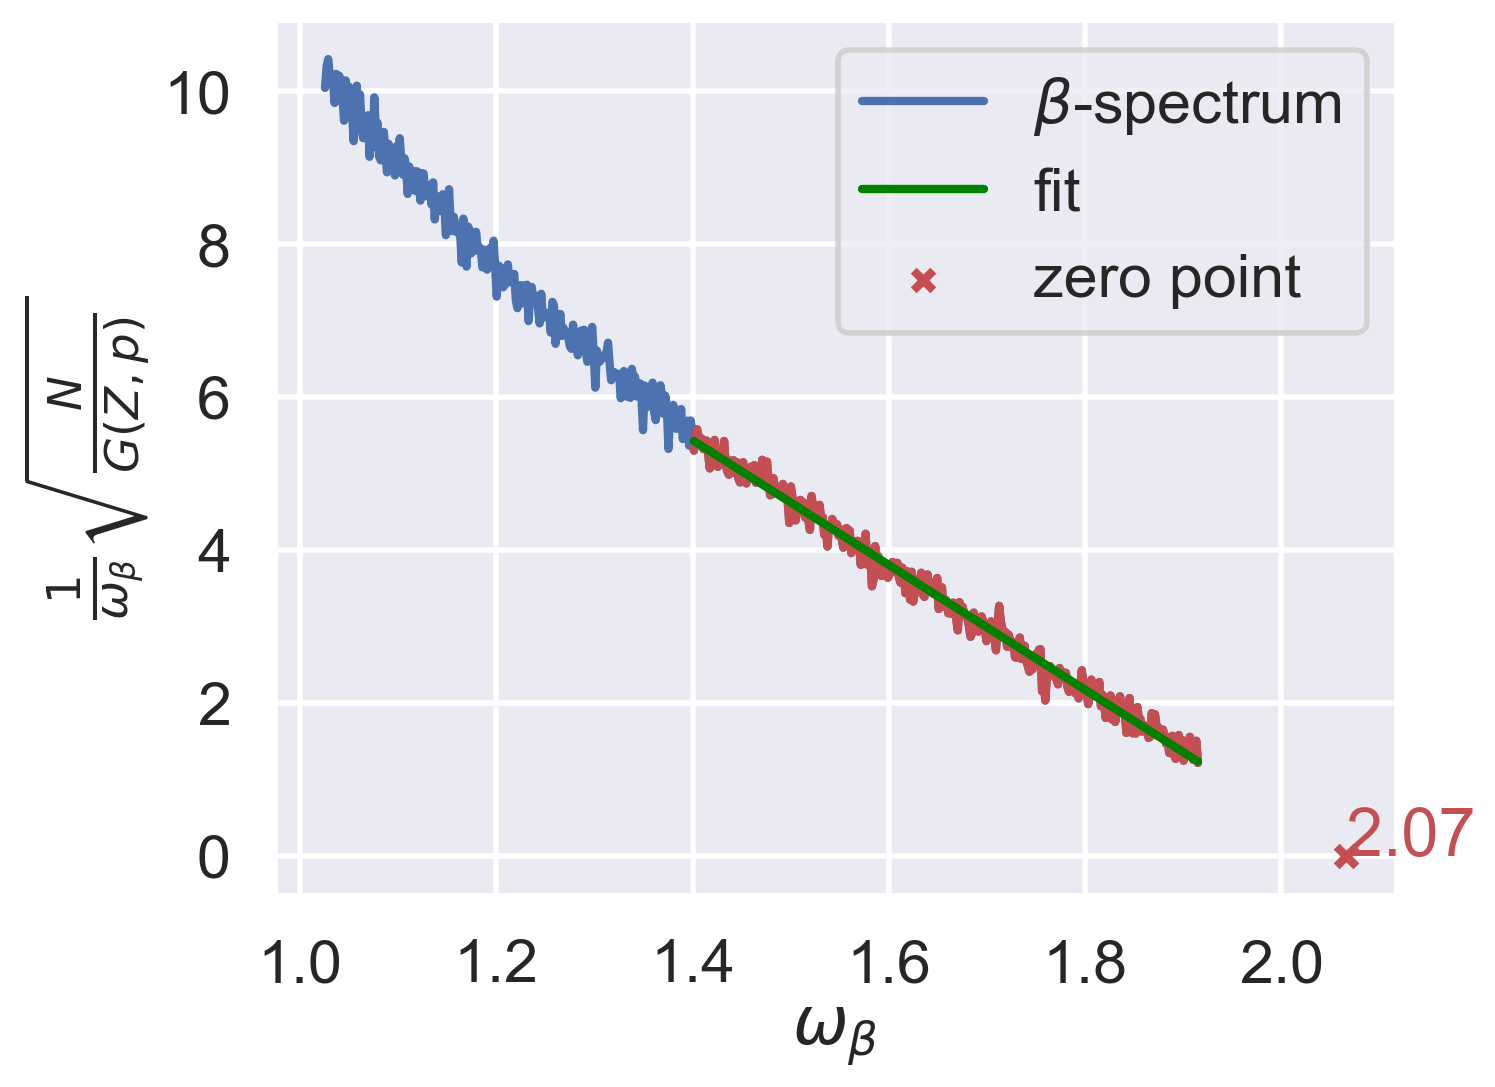

In [101]:
fig

In [102]:
omega_max0 = omega_max
E_max = (omega_max-1)*0.511
E_max0 = 0.5116
print(E_max)
print((E_max-E_max0)/E_max0*100)

0.5447676704641041
6.483125579379216


## Correlation

In [103]:
T_half = 30.08*u.year
T_half = T_half.to('s')
T_half = T_half.value
np.log10(T_half)

8.977381799004831

In [104]:
def S1(omega,omega_max):
    return (omega**2-1)+(omega_max - omega)**2

def S2(omega,omega_max):
    return (omega**2-1)+(omega_max - omega)**4+10/3*(omega**2-1)*(omega_max - omega)**2

0.5069967367974738
-0.8997777956462552


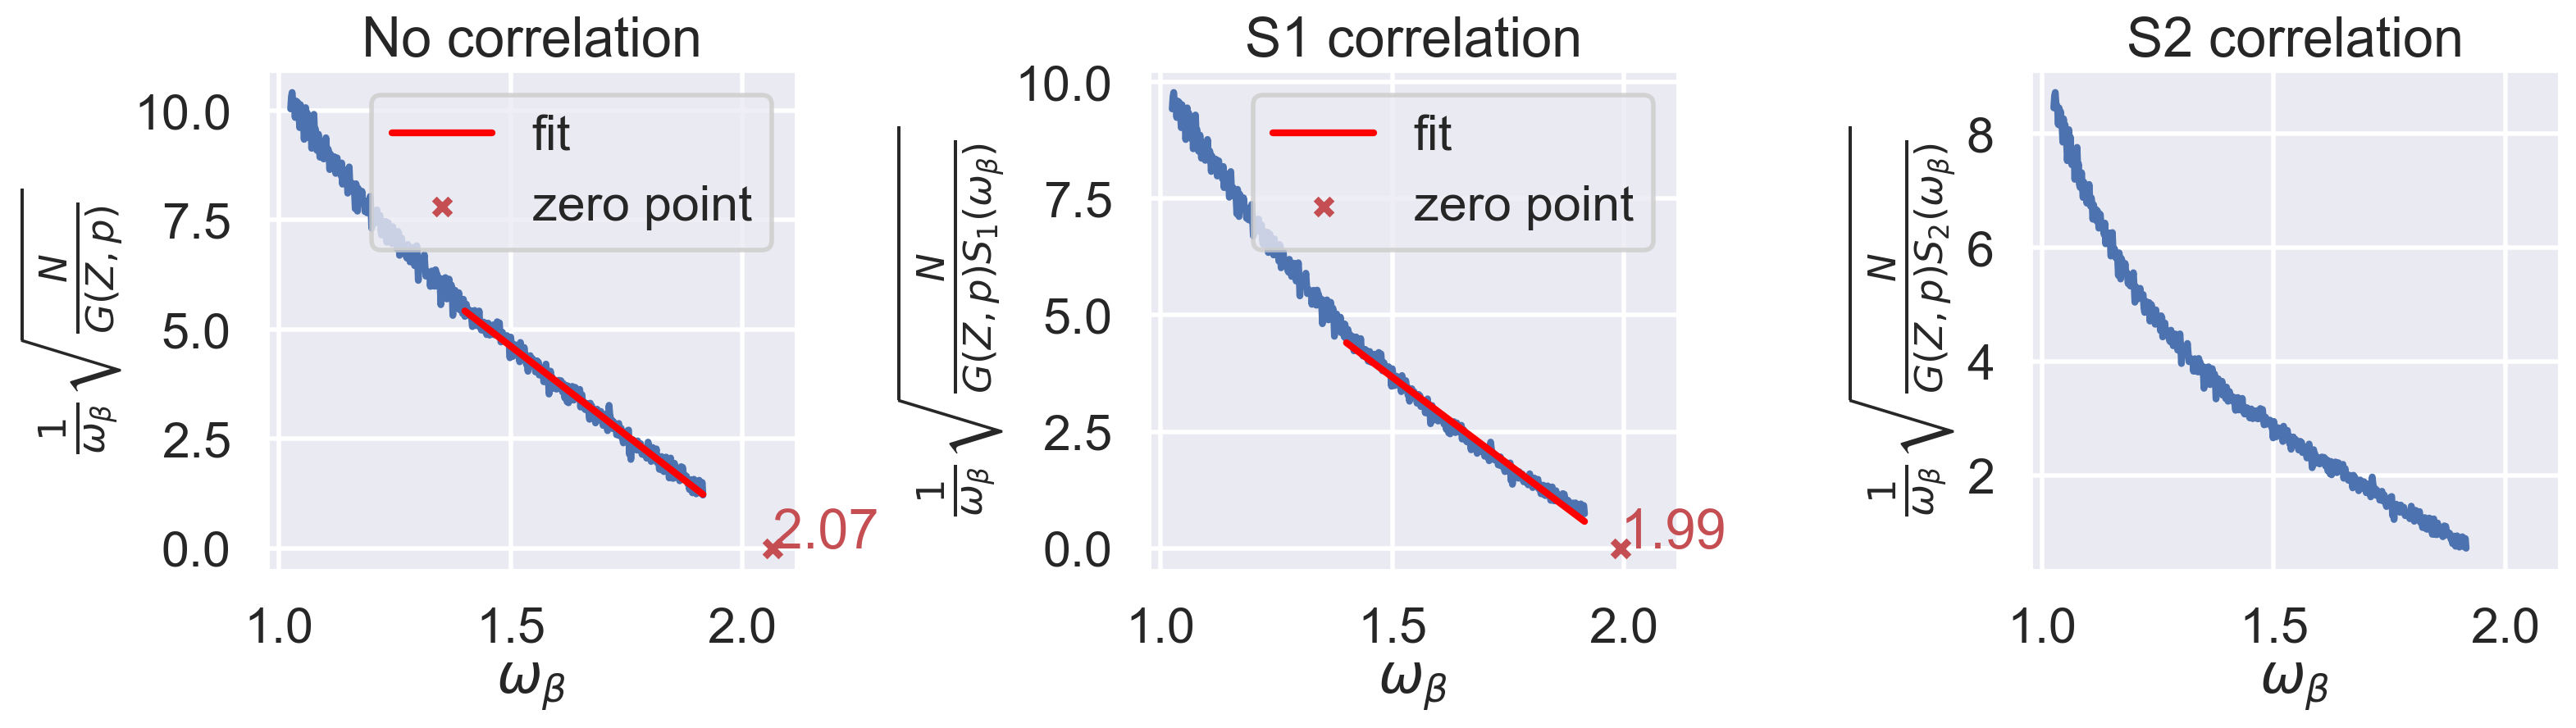

In [112]:
# omega_max = 0.5116
Y_omega_mod = Y_omega/np.sqrt(S1(omega_spectrum_noinner,omega_max0))
                          
fig,axes = plt.subplots(1,3,figsize = (16,5),sharex=True)
axes[0].plot(omega_spectrum_noinner,Y_omega)#,label = r'No correlation')
axes[0].set_title(r'No correlation')
axes[0].set_xlabel(r'$\omega_\beta$')
axes[0].set_ylabel(r'$\frac{1}{\omega_\beta}\sqrt{\frac{N}{G(Z,p)}}$')
axes[1].plot(omega_spectrum_noinner,Y_omega_mod)
            #  label = r'S1 correlation')
axes[1].set_title(r'S1 correlation')
axes[1].set_xlabel(r'$\omega_\beta$')
axes[1].set_ylabel(r'$\frac{1}{\omega_\beta}\sqrt{\frac{N}{G(Z,p) S_1(\omega_\beta)}}$')
axes[2].plot(omega_spectrum_noinner,Y_omega/np.sqrt(S2(omega_spectrum_noinner,omega_max0)))#,
            #  label = r'S2 correlation')
axes[2].set_title(r'S2 correlation')
axes[2].set_xlabel(r'$\omega_\beta$')
axes[2].set_ylabel(r'$\frac{1}{\omega_\beta}\sqrt{\frac{N}{G(Z,p) S_2(\omega_\beta)}}$')

model = LinearModel()
selection = omega_spectrum_noinner>1.4
result = model.fit(Y_omega[selection],x = omega_spectrum_noinner[selection])
axes[0].plot(omega_spectrum_noinner[selection], result.best_fit, 'red', label='fit')
omega_max = -result.params['intercept'].value/result.params['slope'].value
axes[0].scatter(omega_max,0,marker='x',color='r',s=50,label = 'zero point')
axes[0].text(omega_max,0,f'{omega_max:.2f}',color='r')
axes[0].legend()

model = LinearModel()
selection = omega_spectrum_noinner>1.4
result = model.fit(Y_omega_mod[selection],x = omega_spectrum_noinner[selection])
axes[1].plot(omega_spectrum_noinner[selection], result.best_fit, 'red', label='fit')
omega_max = -result.params['intercept'].value/result.params['slope'].value
axes[1].scatter(omega_max,0,marker='x',color='r',s=50,label = 'zero point')
axes[1].text(omega_max,0,f'{omega_max:.2f}',color='r')
axes[1].legend()
fig.tight_layout()
fig.savefig(path+'mod_K_plot.pdf')

E_max = (omega_max-1)*0.511
E_max0 = 0.5116
print(E_max)
print((E_max-E_max0)/E_max0*100)

# RAW

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 5
    # variables        = 2
    chi-square         = 533.195196
    reduced chi-square = 177.731732
    Akaike info crit   = 27.3472483
    Bayesian info crit = 26.5661242
    R-squared          = 0.99730143
[[Variables]]
    slope:      36.0186453 +/- 1.08173468 (3.00%) (init = 1)
    intercept: -82.7350679 +/- 15.9540281 (19.28%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9275


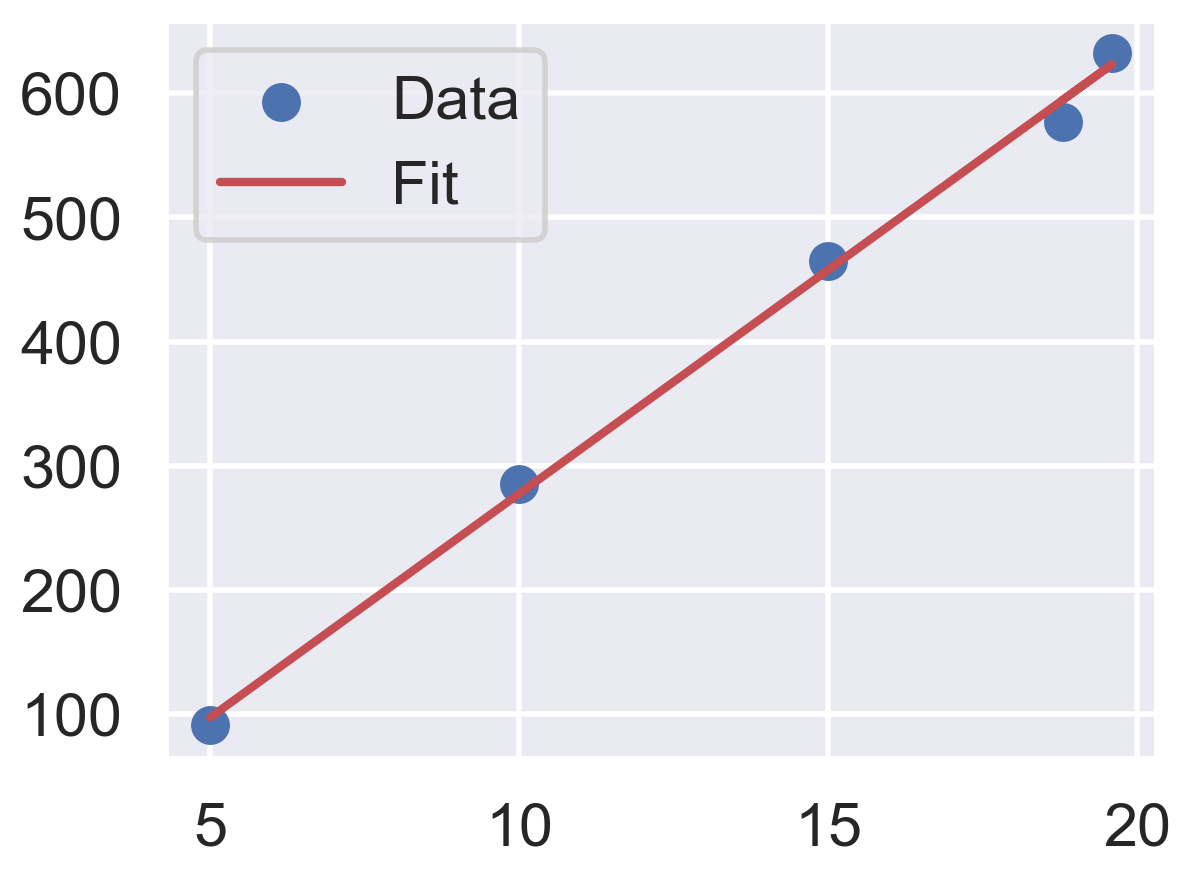

In [64]:
from lmfit.models import LinearModel
import matplotlib.pyplot as plt

# Create data
x = [18.8,19.6,15.0,10.0,5.0]
y = [577,632,465,285,91]

# Initialize the linear model and fit the data
linear_model = LinearModel()
fit_result = linear_model.fit(y, x=x)

# Print the fit report
print(fit_result.fit_report())

# Plot the data and fitted line
plt.scatter(x, y, label='Data')
plt.plot(x, fit_result.best_fit, label='Fit', color='r')
plt.legend()
plt.show()

In [65]:
import pandas as pd

# Given data
x = [18.8, 19.6, 15.0, 10.0, 5.0]
y = [577, 632, 465, 285, 91]

# Create a DataFrame
data = {r'amplitude(mV)': x, 'Peak_position': y}
df = pd.DataFrame(data)

# Display the DataFrame
# df.to_csv('linear_celibration.csv')

In [66]:
fit_result